# FORECASTING  ARIMA

Applying statistical modeling and machine learning to perform time-series forecasting.

What techniques may help answer these questions?

Statistical models

Ignore the time-series aspect completely and model using traditional 

statistical modeling toolbox. 

Examples. Regression-based models. 
Univariate statistical time-series modeling.

Examples. Averaging and smoothing models, ARIMA models.

Slight modifications to univariate statistical time-series modeling.

Examples. External regressors, multi-variate models.

Additive or component models.

Examples. Facebook Prophet package.

Structural time series modeling.

Examples. Bayesian structural time series modeling, hierarchical time series modeling.

Machine learning models

Examples. Support Vector Machines (SVMs), Random Forest Regression, Gradient-Boosted Decision Trees (GBDTs).

Hidden markov models (HMMs).

Other sequence-based models.

Gaussian processes (GPs).

Recurrent neural networks (RNNs).

Additional data considerations before choosing a model

Whether or not to incorporate external data

Whether or not to keep as univariate or multivariate (i.e., which features and number of features)

Outlier detection and removal

Missing value imputation


In [1]:
import pandas as pd
import numpy as np
h_m_df = pd.read_csv('C:/scripts/capstone2/h_m_df2.csv', index_col='DATE', parse_dates=True)

X = np.array(h_m_df.drop(['ASPUS_M'],1))
y = np.array(h_m_df['ASPUS_M'])
h_m_df.head()

ASPUS_M
DATE               
1962-01-01  19300.0
1962-02-01  19300.0
1962-03-01  19300.0
1962-04-01  19300.0
1962-05-01  19300.0

Plot my data
There does appear to be an overall increasing trend. 
There appears to be some differences in the variance over time. 
There may be some seasonality (i.e., cycles) in the data.
Not sure about outliers.

In [2]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score

# Plot time series data
f, ax = plt.subplots(1,1)
ax.plot(h_m_df['ASPUS_M'])

# Add title
ax.set_title('Time-series graph for Monly time-series for Average US Housing Price')

# Rotate x-labels
ax.tick_params(axis = 'x', rotation = 45)

# Show graph
plt.show()

<Figure size 640x480 with 1 Axes>

# Look at stationarity

Most time-series models assume that the underlying time-series data is stationary. This assumption gives us some nice statistical properties that allows us to use various models for forecasting.
Stationarity is a statistical assumption that a time-series has:

    Constant mean
    Constant variance
    Autocovariance does not depend on time
More simply put, if we are using past data to predict future data, we should assume that the data will follow the same general trends and patterns as in the past. This general statement holds for most training data and modeling tasks.

Sometimes we need to transform the data in order to make it stationary. However, this transformation then calls into question if this data is truly stationary and is suited to be modeled using these techniques.

Looking at our data:
Rolling mean and standard deviation look like they change over time. There may be some de-trending and removing seasonality involved. Based on Dickey-Fuller test, because p = 0.31, we fail to reject the null hypothesis (that the time series is not stationary) at the p = 0.05 level, thus concluding that we fail to reject the null hypothesis that our time series is not stationary.


In [3]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(df, ts):
    """
    Test stationarity using moving average statistics and Dickey-Fuller test
    Source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    """
    
    # Determing rolling statistics
    rolmean = df[ts].rolling(window = 12, center = False).mean()
    rolstd = df[ts].rolling(window = 12, center = False).std()
    
    # Plot rolling statistics:
    orig = plt.plot(df[ts], 
                    color = 'blue', 
                    label = 'Original')
    mean = plt.plot(rolmean, 
                    color = 'red', 
                    label = 'Rolling Mean')
    std = plt.plot(rolstd, 
                   color = 'black', 
                   label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for %s' %(ts))
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()
    
    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[ts], 
                      autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index = ['Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

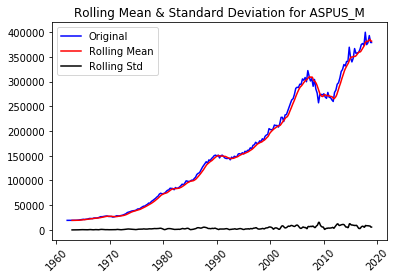

Results of Dickey-Fuller Test:
Test Statistic                  -0.072347
p-value                          0.952124
# Lags Used                     16.000000
Number of Observations Used    667.000000
Critical Value (1%)             -3.440192
Critical Value (5%)             -2.865883
Critical Value (10%)            -2.569083
dtype: float64


In [4]:
test_stationarity(df=h_m_df, ts='ASPUS_M')

p-value is high

# Correct for stationarity

It is common for time series data to have to correct for non-stationarity. 
2 common reasons behind non-stationarity are:
    Trend – mean is not constant over time.
    Seasonality – variance is not constant over time.
There are ways to correct for trend and seasonality, to make the time series stationary.

What happens if you do not correct for these things?
Many things can happen, including:
Variance can be mis-specified
Model fit can be worse. 
Not leveraging valuable time-dependent nature of the data. 


Eliminating trend and seasonality
Transformation
    Examples. Log, square root, etc.
    We are going to look at log.
Smoothing
    Examples. Weekly average, monthly average, rolling averages.
We are going to look at Monthly & Yearly average.
Differencing
    Examples. First-order differencing.
    We are going to look at first-order differencing.
Polynomial Fitting
    Examples. Fit a regression model.
Decomposition

Transformation, Smoothing, and Differencing
Looking at our data:
Applying log transformation, weekly moving average smoothing, and differencing made the data more stationary over time. Based on Dickey-Fuller test, because p = < 0.05, we fail to reject the null hypothesis (that the time series is not stationary) at the p = 0.05 level, thus concluding that the time series is stationary

In [5]:
def plot_transformed_data(df, ts, ts_transform):
  """
  Plot transformed and original time series data
  """
  # Plot time series data
  f, ax = plt.subplots(1,1)
  ax.plot(df[ts])
  ax.plot(df[ts_transform], color = 'red')

  # Add title
  ax.set_title('%s and %s time-series graph' %(ts, ts_transform))

  # Rotate x-labels
  ax.tick_params(axis = 'x', rotation = 45)

  # Add legend
  ax.legend([ts, ts_transform])
  
  plt.show()
  plt.close()
  
  return

In [6]:
h_m_df['ASPUS_M']
# Transformation - log ASPUS_M
h_m_df['ASPUS_M_log'] = h_m_df['ASPUS_M'].apply(lambda x: np.log(x))

# Transformation - 7-day moving averages of log ASPUS_M
h_m_df['ASPUS_M_log_moving_avg'] = h_m_df['ASPUS_M_log'].rolling(window = 7,
                                                               center = False).mean()

# Transformation - 7-day moving average ASPUS_M
h_m_df['ASPUS_M_moving_avg'] = h_m_df['ASPUS_M'].rolling(window = 7,
                                                       center = False).mean()

# Transformation - Difference between logged ASPUS_M and first-order difference logged ASPUS_M
# h_m_df['ASPUS_M_log_diff'] = h_m_df['ASPUS_M_log'] - h_m_df['ASPUS_M_log'].shift()
h_m_df['ASPUS_M_log_diff'] = h_m_df['ASPUS_M_log'].diff()

# Transformation - Difference between ASPUS_M and moving average ASPUS_M
h_m_df['ASPUS_M_moving_avg_diff'] = h_m_df['ASPUS_M'] - h_m_df['ASPUS_M_moving_avg']

# Transformation - Difference between logged ASPUS_M and logged moving average ASPUS_M
h_m_df['ASPUS_M_log_moving_avg_diff'] = h_m_df['ASPUS_M_log'] - h_m_df['ASPUS_M_log_moving_avg']

# Transformation - Difference between logged ASPUS_M and logged moving average ASPUS_M
h_m_df_transform = h_m_df.dropna()

# Transformation - Logged exponentially weighted moving averages (EWMA) ASPUS_M
h_m_df_transform['ASPUS_M_log_ewma'] = h_m_df_transform['ASPUS_M_log'].ewm(halflife = 7,
                                                                         ignore_na = False,
                                                                         min_periods = 0,
                                                                         adjust = True).mean()

# Transformation - Difference between logged ASPUS_M and logged EWMA ASPUS_M
h_m_df_transform['ASPUS_M_log_ewma_diff'] = h_m_df_transform['ASPUS_M_log'] - h_m_df_transform['ASPUS_M_log_ewma']

C:\Users\achow\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\achow\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ASPUS_M  ASPUS_M_log  ASPUS_M_log_moving_avg  ASPUS_M_moving_avg  \
DATE                                                                           
1962-07-01  19300.0      9.86786                 9.86786             19300.0   
1962-08-01  19300.0      9.86786                 9.86786             19300.0   
1962-09-01  19300.0      9.86786                 9.86786             19300.0   
1962-10-01  19300.0      9.86786                 9.86786             19300.0   
1962-11-01  19300.0      9.86786                 9.86786             19300.0   

            ASPUS_M_log_diff  ASPUS_M_moving_avg_diff  \
DATE                                                    
1962-07-01               0.0                      0.0   
1962-08-01               0.0                      0.0   
1962-09-01               0.0                      0.0   
1962-10-01               0.0                      0.0   
1962-11-01               0.0                      0.0   

            ASPUS_M_log_moving_avg_diff  ASPUS_M_log_ewma  \
DATE                                                        
1962-07-01                 1.776357e-15           9.86786   
1962-08-01                 1.776357e-15           9.86786   
1962-09-01                 1.776357e-15           9.86786   
1962-10-01                 1.776357e-15           9.86786   
1962-11-01                 1.776357e-15           9.86786   

            ASPUS_M_log_ewma_diff  
DATE                               
1962-07-01                    0.0  
1962-08-01                    0.0  
1962-09-01                    0.0  
1962-10-01                    0.0  
1962-11-01                    0.0

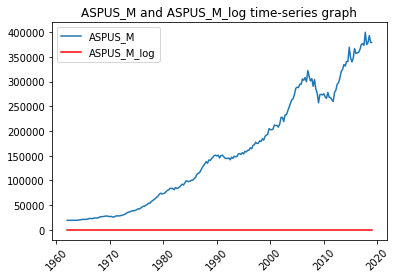

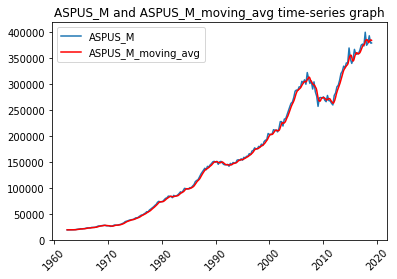

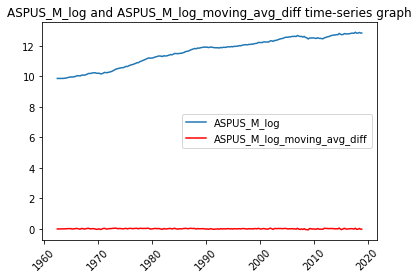

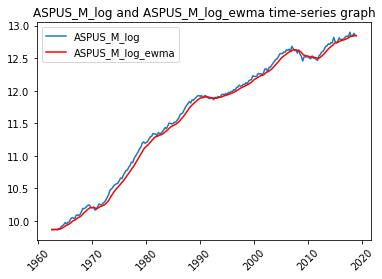

Results of Dickey-Fuller Test:
Test Statistic                  -2.056796
p-value                          0.262238
# Lags Used                     13.000000
Number of Observations Used    664.000000
Critical Value (1%)             -3.440237
Critical Value (5%)             -2.865903
Critical Value (10%)            -2.569093
dtype: float64


In [7]:
# Display data
display(h_m_df_transform.head())

# Plot data
plot_transformed_data(df = h_m_df, 
                      ts = 'ASPUS_M', 
                      ts_transform = 'ASPUS_M_log')
# Plot data
plot_transformed_data(df = h_m_df, 
                      ts = 'ASPUS_M_log', 
                      ts_transform = 'ASPUS_M_log_moving_avg')

# Plot data
plot_transformed_data(df = h_m_df_transform, 
                      ts = 'ASPUS_M', 
                      ts_transform = 'ASPUS_M_moving_avg')

# Plot data
plot_transformed_data(df = h_m_df_transform, 
                      ts = 'ASPUS_M_log', 
                      ts_transform = 'ASPUS_M_log_diff')

# Plot data
plot_transformed_data(df = h_m_df_transform, 
                      ts = 'ASPUS_M', 
                      ts_transform = 'ASPUS_M_moving_avg_diff')

# Plot data
plot_transformed_data(df = h_m_df_transform, 
                      ts = 'ASPUS_M_log', 
                      ts_transform = 'ASPUS_M_log_moving_avg_diff')

# Plot data
plot_transformed_data(df = h_m_df_transform, 
                      ts = 'ASPUS_M_log', 
                      ts_transform = 'ASPUS_M_log_ewma')

# Plot data
plot_transformed_data(df = h_m_df_transform, 
                      ts = 'ASPUS_M_log', 
                      ts_transform = 'ASPUS_M_log_ewma_diff')

# Perform stationarity test
h_m_df['ASPUS_M_log']
test_stationarity(df = h_m_df_transform, 
                  ts = 'ASPUS_M_log')


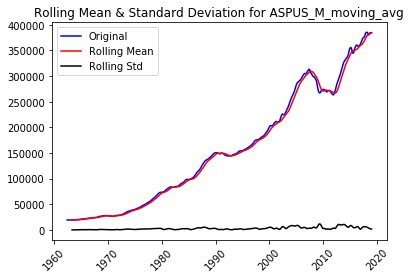

Results of Dickey-Fuller Test:
Test Statistic                   0.241124
p-value                          0.974476
# Lags Used                     20.000000
Number of Observations Used    657.000000
Critical Value (1%)             -3.440342
Critical Value (5%)             -2.865949
Critical Value (10%)            -2.569118
dtype: float64


Results of Dickey-Fuller Test:
Test Statistic                  -2.033433
p-value                          0.272109
# Lags Used                     20.000000
Number of Observations Used    657.000000
Critical Value (1%)             -3.440342
Critical Value (5%)             -2.865949
Critical Value (10%)            -2.569118
dtype: float64


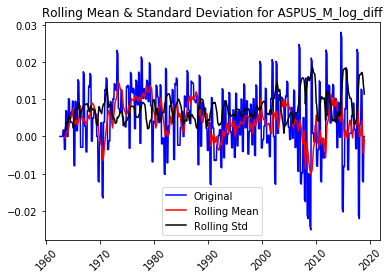

Results of Dickey-Fuller Test:
Test Statistic                  -4.021809
p-value                          0.001301
# Lags Used                     12.000000
Number of Observations Used    665.000000
Critical Value (1%)             -3.440222
Critical Value (5%)             -2.865896
Critical Value (10%)            -2.569090
dtype: float64


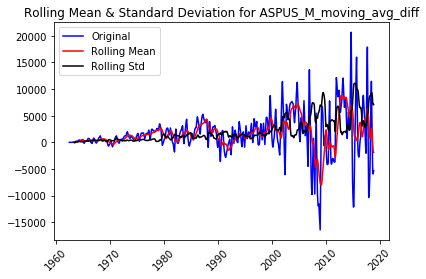

Results of Dickey-Fuller Test:
Test Statistic                  -3.882004
p-value                          0.002171
# Lags Used                     16.000000
Number of Observations Used    661.000000
Critical Value (1%)             -3.440282
Critical Value (5%)             -2.865922
Critical Value (10%)            -2.569104
dtype: float64


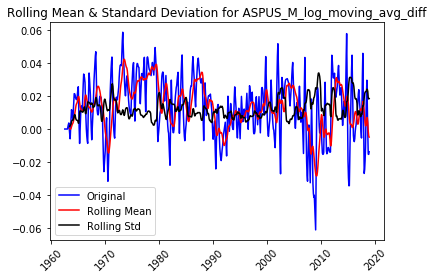

Results of Dickey-Fuller Test:
Test Statistic                  -4.148018
p-value                          0.000806
# Lags Used                     13.000000
Number of Observations Used    664.000000
Critical Value (1%)             -3.440237
Critical Value (5%)             -2.865903
Critical Value (10%)            -2.569093
dtype: float64


Results of Dickey-Fuller Test:
Test Statistic                  -2.101725
p-value                          0.243821
# Lags Used                     14.000000
Number of Observations Used    663.000000
Critical Value (1%)             -3.440252
Critical Value (5%)             -2.865909
Critical Value (10%)            -2.569097
dtype: float64


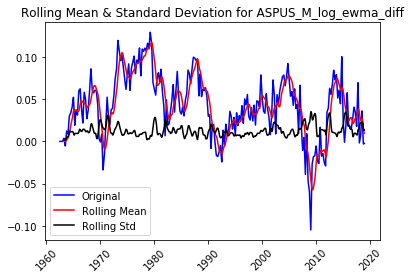

Results of Dickey-Fuller Test:
Test Statistic                  -3.496422
p-value                          0.008079
# Lags Used                     13.000000
Number of Observations Used    664.000000
Critical Value (1%)             -3.440237
Critical Value (5%)             -2.865903
Critical Value (10%)            -2.569093
dtype: float64


In [8]:
# Perform stationarity test
test_stationarity(df = h_m_df_transform, 
                  ts = 'ASPUS_M_moving_avg')

# Perform stationarity test
test_stationarity(df = h_m_df_transform, 
                  ts = 'ASPUS_M_log_moving_avg')

# Perform stationarity test
test_stationarity(df = h_m_df_transform,
                  ts = 'ASPUS_M_log_diff')
#p-value                          0.001301

# Perform stationarity test
test_stationarity(df = h_m_df_transform,
                  ts = 'ASPUS_M_moving_avg_diff')
#p-value                          0.002171

# Perform stationarity test
test_stationarity(df = h_m_df_transform,
                  ts = 'ASPUS_M_log_moving_avg_diff')
#p-value                         0.000806  BEST

# Perform stationarity test
test_stationarity(df = h_m_df_transform, 
                  ts = 'ASPUS_M_log_ewma')

# Perform stationarity test
test_stationarity(df = h_m_df_transform,
                  ts ='ASPUS_M_log_ewma_diff')
#p-value                          0.008079

# Decomposition: trend, seasonality, residuals¶
Looking at our data:
De-trending and de-seasonalizing made the data (i.e., the residuals) more stationary over time. Based on Dickey-Fuller test, because p = < 0.05, we fail to reject the null hypothesis (that the time series is not stationary) at the p = 0.05 level, thus concluding that the time series is stationary.

In [9]:
def plot_decomposition(df, ts, trend, seasonal, residual):
  """
  Plot time series data
  """
  f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (15, 5), sharex = True)

  ax1.plot(df[ts], label = 'Original')
  ax1.legend(loc = 'best')
  ax1.tick_params(axis = 'x', rotation = 45)

  ax2.plot(df[trend], label = 'Trend')
  ax2.legend(loc = 'best')
  ax2.tick_params(axis = 'x', rotation = 45)

  ax3.plot(df[seasonal],label = 'Seasonality')
  ax3.legend(loc = 'best')
  ax3.tick_params(axis = 'x', rotation = 45)

  ax4.plot(df[residual], label = 'Residuals')
  ax4.legend(loc = 'best')
  ax4.tick_params(axis = 'x', rotation = 45)
  plt.tight_layout()

  # Show graph
  plt.suptitle('Trend, Seasonal, and Residual Decomposition of %s' %(ts), 
               x = 0.5, 
               y = 1.05, 
               fontsize = 18)
  plt.show()
  plt.close()
  
  return

C:\Users\achow\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\achow\Anaconda3\lib\site-packages\pandas\core\indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


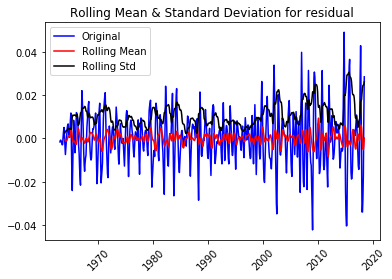

Results of Dickey-Fuller Test:
Test Statistic                -9.973922e+00
p-value                        2.203119e-17
# Lags Used                    1.900000e+01
Number of Observations Used    6.460000e+02
Critical Value (1%)           -3.440513e+00
Critical Value (5%)           -2.866024e+00
Critical Value (10%)          -2.569158e+00
dtype: float64


In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(h_m_df_transform['ASPUS_M_log_moving_avg_diff'], freq = 12)

h_m_df_transform.loc[:,'trend'] = decomposition.trend
h_m_df_transform.loc[:,'seasonal'] = decomposition.seasonal
h_m_df_transform.loc[:,'residual'] = decomposition.resid

plot_decomposition(df = h_m_df_transform, 
                   ts = 'ASPUS_M_log_moving_avg_diff', 
                   trend = 'trend',
                   seasonal = 'seasonal', 
                   residual = 'residual')

test_stationarity(df = h_m_df_transform.dropna(), ts = 'residual')


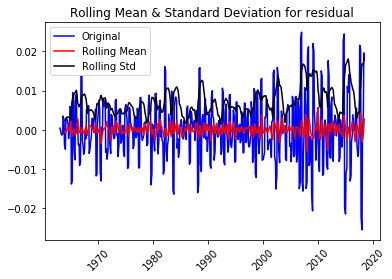

Results of Dickey-Fuller Test:
Test Statistic                -1.130012e+01
p-value                        1.313798e-20
# Lags Used                    1.700000e+01
Number of Observations Used    6.480000e+02
Critical Value (1%)           -3.440482e+00
Critical Value (5%)           -2.866011e+00
Critical Value (10%)          -2.569151e+00
dtype: float64


In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(h_m_df_transform['ASPUS_M_log_diff'], freq = 12)

h_m_df_transform.loc[:,'trend'] = decomposition.trend
h_m_df_transform.loc[:,'seasonal'] = decomposition.seasonal
h_m_df_transform.loc[:,'residual'] = decomposition.resid

plot_decomposition(df = h_m_df_transform, 
                   ts = 'ASPUS_M_log_diff', 
                   trend = 'trend',
                   seasonal = 'seasonal', 
                   residual = 'residual')

test_stationarity(df = h_m_df_transform.dropna(), ts = 'residual')

# Let us model some time-series data! Finally! ARIMA models.

We will be doing an example here! We can use ARIMA models when we know there is dependence between values and we can leverage that information to forecast.
ARIMA = Auto-Regressive Integrated Moving Average.
Assumptions. The time-series is stationary.
Depends on:
1. Number of AR (Auto-Regressive) terms (p).
2. Number of I (Integrated or Difference) terms (d).
3. Number of MA (Moving Average) terms (q). 

ACF and PACF Plots
How do we determine p, d, and q? For p and q, we can use ACF and PACF plots (below).
Autocorrelation Function (ACF). Correlation between the time series with a lagged version of itself (e.g., correlation of Y(t) with Y(t-1)).
Partial Autocorrelation Function (PACF). Additional correlation explained by each successive lagged term.
How do we interpret ACF and PACF plots?
p – Lag value where the PACF chart crosses the upper confidence interval for the first time.
q – Lag value where the ACF chart crosses the upper confidence interval for the first time.

In [12]:
def plot_acf_pacf(df, ts):
  """
  Plot auto-correlation function (ACF) and partial auto-correlation (PACF) plots
  """
  f, (ax1, ax2) = plt.subplots(1,2, figsize = (10, 5)) 

  #Plot ACF: 

  ax1.plot(lag_acf)
  ax1.axhline(y=0,linestyle='--',color='gray')
  ax1.axhline(y=-1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax1.axhline(y=1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax1.set_title('Autocorrelation Function for %s' %(ts))

  #Plot PACF:
  ax2.plot(lag_pacf)
  ax2.axhline(y=0,linestyle='--',color='gray')
  ax2.axhline(y=-1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax2.axhline(y=1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax2.set_title('Partial Autocorrelation Function for %s' %(ts))
  
  plt.tight_layout()
  plt.show()
  plt.close()
  
  return

In [13]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

# determine ACF and PACF
lag_acf = acf(np.array(h_m_df_transform['ASPUS_M_log_moving_avg_diff']), nlags = 60)
lag_pacf = pacf(np.array(h_m_df_transform['ASPUS_M_log_moving_avg_diff']), nlags = 60)

# plot ACF and PACF
plot_acf_pacf(df = h_m_df_transform, ts = 'ASPUS_M_log_moving_avg_diff')


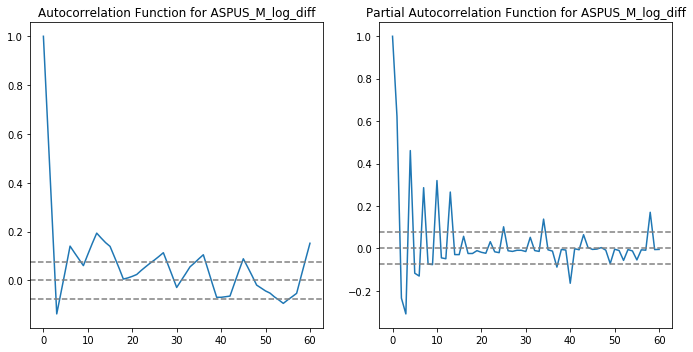

In [14]:
from statsmodels.tsa.stattools import acf, pacf

# determine ACF and PACF
lag_acf = acf(np.array(h_m_df_transform['ASPUS_M_log_diff']), nlags = 60)
lag_pacf = pacf(np.array(h_m_df_transform['ASPUS_M_log_diff']), nlags = 60)

# plot ACF and PACF
plot_acf_pacf(df = h_m_df_transform, ts = 'ASPUS_M_log_diff')


In [15]:
#unc arima
def run_arima_model(df, ts, p, d, q):
  """
  Run ARIMA model
  """
  from statsmodels.tsa.arima_model import ARIMA

  # fit ARIMA model on time series
  model = ARIMA(df[ts], order=(p, d, q))  
  results_ = model.fit(disp=-1)  
  
  # get lengths correct to calculate RSS
  len_results = len(results_.fittedvalues)
  ts_modified = df[ts][-len_results:]
  
  # calculate root mean square error (RMSE) and residual sum of squares (RSS)
  rss = sum((results_.fittedvalues - ts_modified)**2)
  rmse = np.sqrt(rss / len(df[ts]))
  
  # plot fit
  plt.plot(df[ts])
  plt.plot(results_.fittedvalues, color = 'red')
  plt.title('For ARIMA model (%i, %i, %i) for ts %s, RSS: %.4f, RMSE: %.4f' %(p, d, q, ts, rss, rmse))
  
  plt.show()
  #plt.close()
  
  return results_

C:\Users\achow\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


C:\Users\achow\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


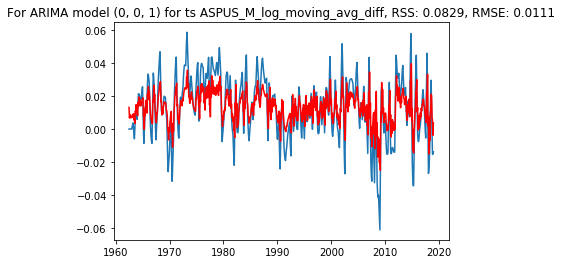

C:\Users\achow\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


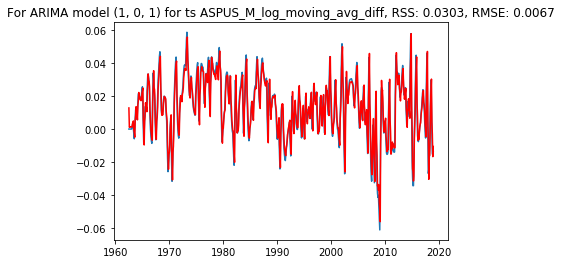

C:\Users\achow\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


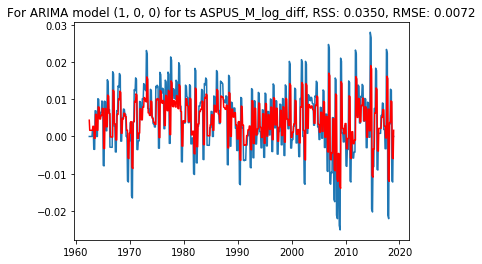

C:\Users\achow\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


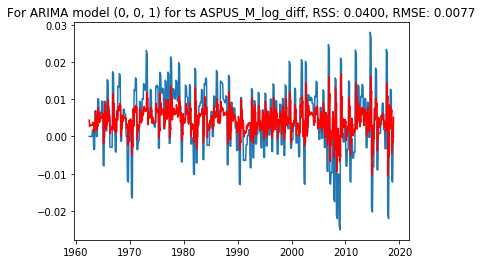

C:\Users\achow\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


C:\Users\achow\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\achow\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


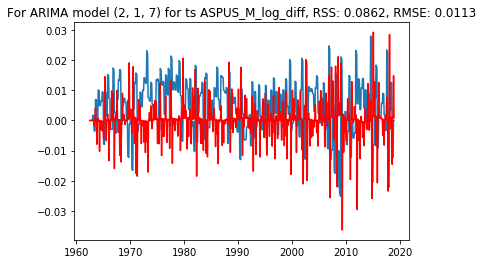

C:\Users\achow\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\achow\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


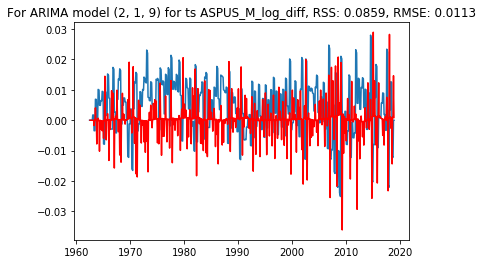

C:\Users\achow\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\achow\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\achow\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


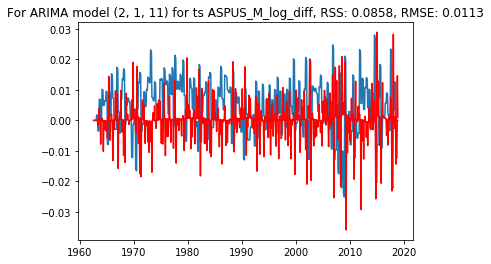

C:\Users\achow\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


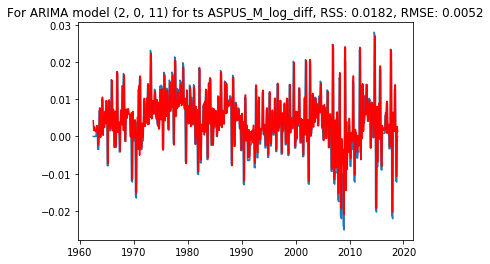

C:\Users\achow\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


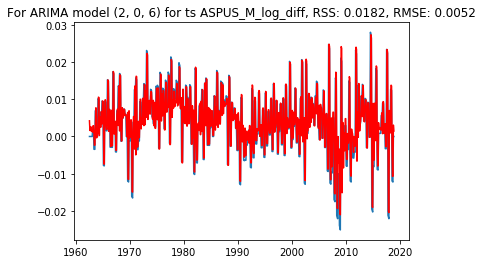

C:\Users\achow\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\achow\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


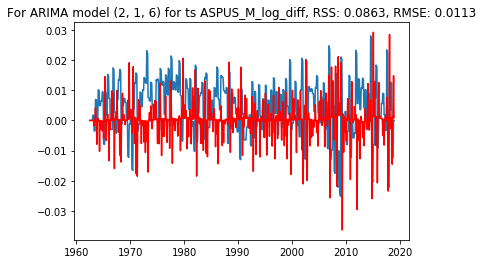

C:\Users\achow\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [16]:
# Note: I do the differencing in the transformation of the data 'ts_log_diff'
# AR model with 1st order differencing - ARIMA (1,0,0)
model_AR_diff = run_arima_model(df = h_m_df_transform, 
                           ts = 'ASPUS_M_log_moving_avg_diff', 
                           p = 1, 
                           d = 0, 
                           q = 0)

# MA model with 1st order differencing - ARIMA (0,0,1)
model_MA_diff = run_arima_model(df = h_m_df_transform, 
                           ts = 'ASPUS_M_log_moving_avg_diff', 
                           p = 0, 
                           d = 0, 
                           q = 1)

# ARMA model with 1st order differencing - ARIMA (1,0,1)
model_MA_diff = run_arima_model(df = h_m_df_transform, 
                           ts = 'ASPUS_M_log_moving_avg_diff', 
                           p = 1, 
                           d = 0, 
                           q = 1)

########
model_AR_log_diff = run_arima_model(df = h_m_df_transform, 
                           ts = 'ASPUS_M_log_diff', 
                           p = 1, 
                           d = 0, 
                           q = 0)

# MA model with 1st order differencing - ARIMA (0,0,1)
model_AR_log_diff = run_arima_model(df = h_m_df_transform, 
                           ts = 'ASPUS_M_log_diff', 
                           p = 0, 
                           d = 0, 
                           q = 1)

# ARMA model with 1st order differencing - ARIMA (1,0,1) BEST
model_AR_log_diff= run_arima_model(df = h_m_df_transform, 
                           ts = 'ASPUS_M_log_diff', 
                           p = 1, 
                           d = 0, 
                           q = 1)

model_AR_log_diff = run_arima_model(df = h_m_df_transform, 
                           ts = 'ASPUS_M_log_diff', 
                           p = 2, 
                           d = 1, 
                           q = 7)

# MA model with 1st order differencing - ARIMA (0,0,1)
model_AR_log_diff = run_arima_model(df = h_m_df_transform, 
                           ts = 'ASPUS_M_log_diff', 
                           p = 2, 
                           d = 1, 
                           q = 9)

# ARMA model with 1st order differencing - ARIMA (1,0,1) BEST
model_AR_log_diff= run_arima_model(df = h_m_df_transform, 
                           ts = 'ASPUS_M_log_diff', 
                           p = 2, 
                           d = 1, 
                           q = 11)

model_AR_log_diff= run_arima_model(df = h_m_df_transform, 
                           ts = 'ASPUS_M_log_diff', 
                           p = 2, 
                           d = 0, 
                           q = 11)

model_AR_log_diff= run_arima_model(df = h_m_df_transform, 
                           ts = 'ASPUS_M_log_diff', 
                           p = 2, 
                           d = 0, 
                           q = 6)

model_AR_log_diff= run_arima_model(df = h_m_df_transform, 
                           ts = 'ASPUS_M_log_diff', 
                           p = 2, 
                           d = 1, 
                           q = 6)

model_AR_log_diff= run_arima_model(df = h_m_df_transform, 
                           ts = 'ASPUS_M_log_diff', 
                           p = 3, 
                           d = 0, 
                           q = 6)

C:\Users\achow\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


The AIC for an AR(1) is:  -4625.277154072418


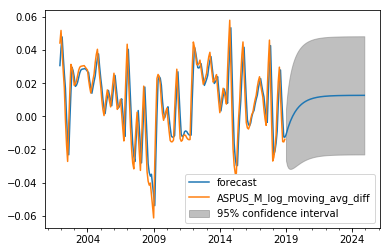

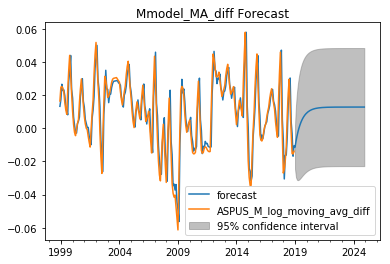

In [17]:
# Import the ARMA module from statsmodels
from statsmodels.tsa.arima_model import ARMA

ASPUS_M_moving_avg_diff=h_m_df_transform['ASPUS_M_log_moving_avg_diff']
ASPUS_M_moving_avg_diff = ARMA(ASPUS_M_moving_avg_diff, order=(1,0, 1))

ASPUS_M_moving_avg_diff = ASPUS_M_moving_avg_diff.fit()
print("The AIC for an AR(1) is: ", ASPUS_M_moving_avg_diff.aic)

ASPUS_M_moving_avg_diff.plot_predict(start='12-01-01', end='12-01-2024')

# Plot the original series and the forecasted series
model_MA_diff.plot_predict(start='12-01-1998', end='12-01-2024')


plt.legend(fontsize=10)
plt.title('Mmodel_MA_diff Forecast')
plt.show()

With 95% confidence interval forecasted data until 2024

C:\Users\achow\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


The AIC for an AR(1) is:  -4763.135877157376
The BIC for an AR(1) is:  -4749.578435293554


C:\Users\achow\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


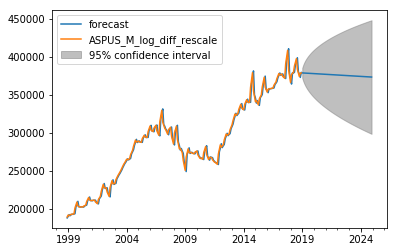

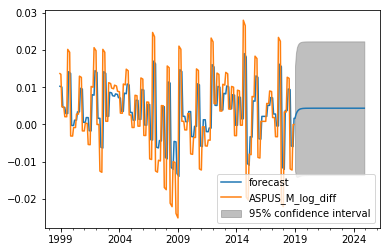

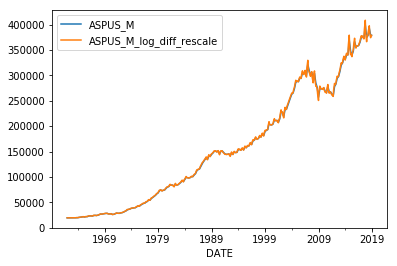

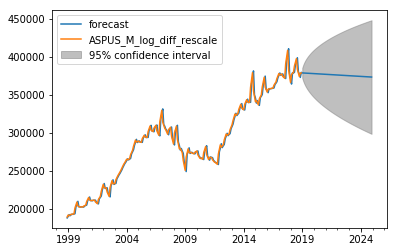

In [18]:
import statsmodels.api as sm
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score

ASPUS_M_log_diff=h_m_df_transform['ASPUS_M_log_diff']
ASPUS_M_log_diff = ARMA(ASPUS_M_log_diff, order=(1,0, 1))

ASPUS_M_log_diff = ASPUS_M_log_diff.fit()
print("The AIC for an AR(1) is: ", ASPUS_M_log_diff.aic)
print("The BIC for an AR(1) is: ", ASPUS_M_log_diff.bic)

h_m_df['ASPUS_M_log_diff_rescale'] = np.exp(h_m_df['ASPUS_M_log_diff'] + h_m_df['ASPUS_M_log'])
h_m_df['ASPUS_M_log_diff_rescale']=h_m_df['ASPUS_M_log_diff_rescale'].fillna(method='bfill')
#viz_df['yhat_rescaled'] = np.exp(viz_df['yhat'])

ASPUS_M_log_diff.plot_predict(start='12-01-98', end='12-01-2024')
h_m_df[['ASPUS_M', 'ASPUS_M_log_diff_rescale']].plot()
#ASPUS_M_log_diff_rescale.plot_predict(start='12-01-01', end='12-01-2024')
X3= h_m_df['ASPUS_M_log_diff_rescale']
X3 = ARMA(X3, order=(3,0,6))  #Good

X3=X3.fit()
X3.plot_predict(start='12-01-98', end='12-01-2024')

[378147.57088496]


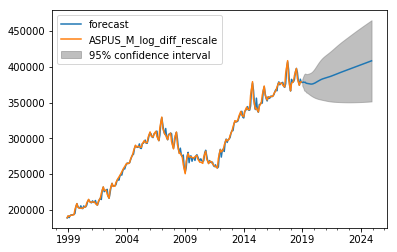

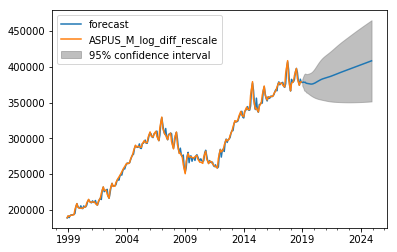

In [19]:
import statsmodels.api as sm
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

ASPUS_M_log_diff=h_m_df_transform['ASPUS_M_log_diff']
#ASPUS_M_log_diff = ARMA(ASPUS_M_log_diff, order=(1,0, 1))
#
#ASPUS_M_log_diff = ASPUS_M_log_diff.fit()

h_m_df['ASPUS_M_log_diff_rescale'] = np.exp(h_m_df['ASPUS_M_log_diff'] + h_m_df['ASPUS_M_log'])
h_m_df['ASPUS_M_log_diff_rescale']=h_m_df['ASPUS_M_log_diff_rescale'].fillna(method='bfill')
#viz_df['yhat_rescaled'] = np.exp(viz_df['yhat'])

#ASPUS_M_log_diff.plot_predict(start='12-01-01', end='12-01-2024')
#
#ASPUS_M_log_diff_rescale.plot_predict(start='12-01-01', end='12-01-2024')
X3= h_m_df['ASPUS_M_log_diff_rescale']
#X3 = ARMA(X3, order=(1,0, 1))
#
#X3=X3.fit()

X3 = sm.tsa.ARIMA(X3, (2, 1, 9)).fit()
predictions = X3.forecast()[0]
print(predictions)
X3.plot_predict(start='12-01-98', end='12-01-2024')

In [20]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.80)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = sqrt(mean_squared_error(test, predictions))
	return error

In [21]:
#X=X3.values
X = h_m_df['ASPUS_M_log_diff_rescale'].values
#r2 = r2_score(X, predictions)

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
                
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue

	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))




In [24]:
print("Please wait for few munites to execute this cell")
import warnings
import math
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

# evaluate parameters
p_values = [0, 1, 2]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(X, p_values, d_values, q_values)

Please wait for few munites to execute this cell
ARIMA(0, 0, 0) RMSE=188696.459
ARIMA(0, 0, 1) RMSE=98193.524
ARIMA(0, 1, 0) RMSE=6620.944
ARIMA(0, 1, 1) RMSE=6520.725
ARIMA(0, 1, 2) RMSE=5264.303
ARIMA(0, 2, 0) RMSE=8360.715
ARIMA(0, 2, 1) RMSE=6699.130
ARIMA(0, 2, 2) RMSE=6566.924
ARIMA(1, 0, 0) RMSE=6642.715
ARIMA(1, 1, 0) RMSE=6509.033
ARIMA(1, 1, 1) RMSE=6513.910
ARIMA(1, 1, 2) RMSE=4835.226
ARIMA(1, 2, 0) RMSE=7664.299
ARIMA(1, 2, 1) RMSE=7375.178
ARIMA(1, 2, 2) RMSE=6713.176
ARIMA(2, 1, 0) RMSE=6533.491
ARIMA(2, 1, 1) RMSE=6253.397
ARIMA(2, 1, 2) RMSE=4920.455
ARIMA(2, 2, 0) RMSE=7674.862
ARIMA(2, 2, 1) RMSE=7411.251
ARIMA(2, 2, 2) RMSE=6270.149
Best ARIMA(1, 1, 2) RMSE=4835.226


In [25]:
from math import sqrt
evaluate_arima_model(X, (1,1,2))
evaluate_arima_model(X, (2,1,6))
# evaluate forecasts
print("The AIC for an AR(1) is: ", X3.aic)
print("The BIC for an AR(1) is: ", X3.bic)
print(X3.summary())

The AIC for an AR(1) is:  12523.134338946318
The BIC for an AR(1) is:  12581.978772120738
                                 ARIMA Model Results                                  
Dep. Variable:     D.ASPUS_M_log_diff_rescale   No. Observations:                  683
Model:                         ARIMA(2, 1, 9)   Log Likelihood               -6248.567
Method:                               css-mle   S.D. of innovations           2264.754
Date:                        Thu, 28 Mar 2019   AIC                          12523.134
Time:                                03:52:47   BIC                          12581.979
Sample:                            02-01-1962   HQIC                         12545.907
                                 - 12-01-2018                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const       

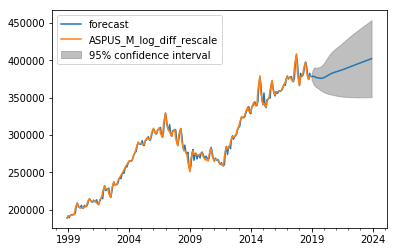

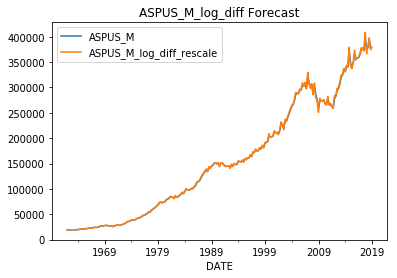

In [30]:
fig, ax = plt.subplots()
X3.plot_predict(start='12-01-1998', end='12-01-2023', ax=ax, dynamic=False, plot_insample=True)

h_m_df[['ASPUS_M', 'ASPUS_M_log_diff_rescale']].plot()

# Plot the original series and the forecasted series
#model_MA_diff.plot_predict(start='12-01-1998', end='12-01-2024')

#X3.plot()
plt.legend(bbox_to_anchor=(1.25, 0.5))
#sns.despine()
plt.legend(fontsize=10)
plt.title('ASPUS_M_log_diff Forecast')
plt.show()

# SARIMAX

In [36]:
from __future__ import absolute_import, division, print_function

%config InlineBackend.figure_format='retina'

import sys
import os

import pandas as pd
import numpy as np

# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')

In [37]:
import pandas as pd
import numpy as np
h_m_df = pd.read_csv('C:/scripts/capstone2/h_m_df2.csv', index_col='DATE', parse_dates=True)
h_m_df.head()
X = np.array(h_m_df.drop(['ASPUS_M'],1))
y = np.array(h_m_df['ASPUS_M'])

h_m_df['ASPUS_M_log'] = h_m_df['ASPUS_M'].apply(lambda x: np.log(x))

h_m_df['ASPUS_M_log_diff'] = h_m_df['ASPUS_M_log'].diff()

ASPUS_M_log_diff

h_m_df['ASPUS_M_log_diff_rescale'] = np.exp(h_m_df['ASPUS_M_log_diff'] + h_m_df['ASPUS_M_log'])
h_m_df['ASPUS_M_log_diff_rescale']=h_m_df['ASPUS_M_log_diff_rescale'].fillna(method='bfill')

ts_df= h_m_df['ASPUS_M_log_diff_rescale']

n_sample = ts_df.shape[0]

print(ts_df.shape)
print(n_sample)
print(ts_df.head())

(684,)
684
DATE
1962-01-01   19300.00000
1962-02-01   19300.00000
1962-03-01   19300.00000
1962-04-01   19300.00000
1962-05-01   19300.00000
Name: ASPUS_M_log_diff_rescale, dtype: float64


In [38]:
# Create a training sample and testing sample before analyzing the series

n_train=int(0.95*n_sample)+1
n_forecast=n_sample-n_train
#ts_df
ts_train = h_m_df.iloc[:n_train]['ASPUS_M_log_diff_rescale']
ts_test = h_m_df.iloc[n_train:]['ASPUS_M_log_diff_rescale']
print(ts_train.shape)
print(ts_test.shape)
print("Training Series Tail:", "\n", ts_train.tail(), "\n")
print("Testing Series Head:", "\n", ts_test.head())


(650,)
(34,)
Training Series Tail: 
 DATE
2015-10-01   373248.21425
2015-11-01   360261.84293
2015-12-01   357028.76305
2016-01-01   353795.68801
2016-02-01   357600.25210
Name: ASPUS_M_log_diff_rescale, dtype: float64 

Testing Series Head: 
 DATE
2016-03-01   357900.25189
2016-04-01   358200.25168
2016-05-01   358500.25147
2016-06-01   358800.25126
2016-07-01   359100.25105
Name: ASPUS_M_log_diff_rescale, dtype: float64


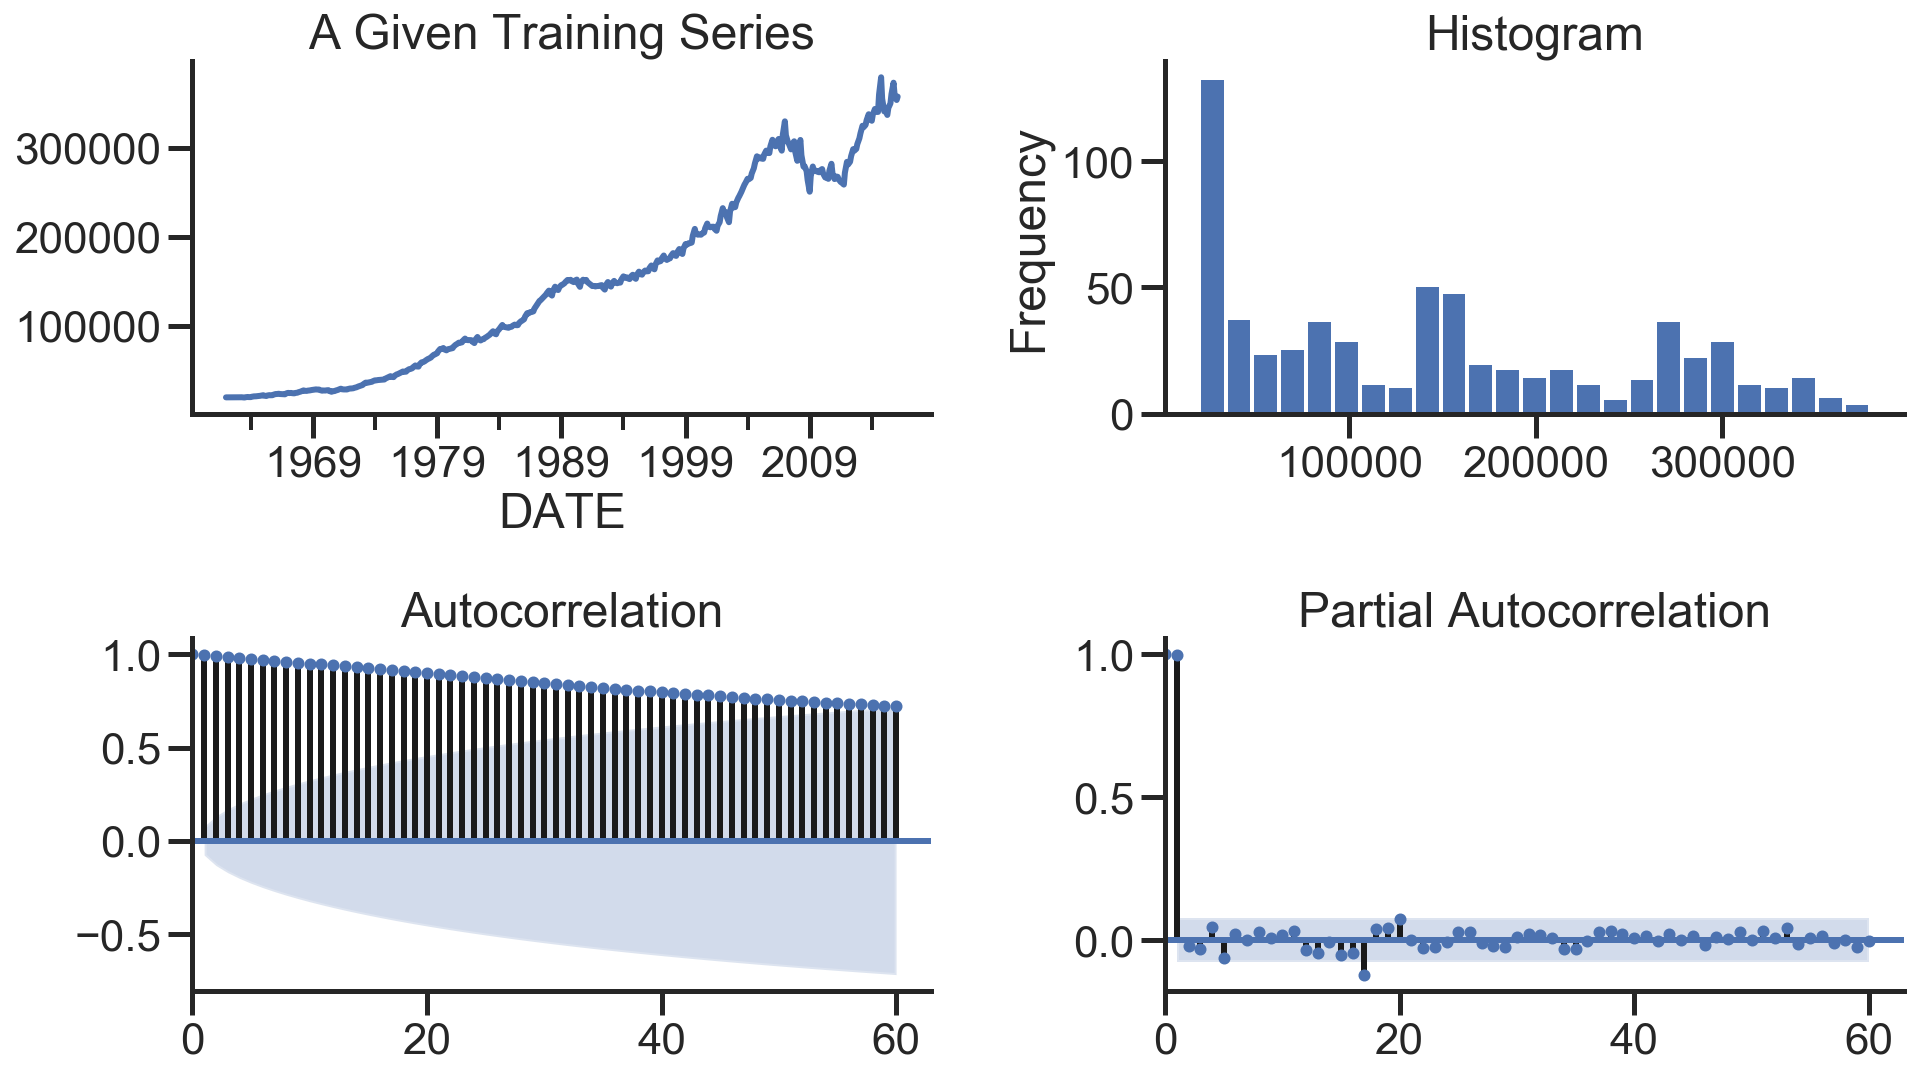

In [39]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax


tsplot(ts_train, title='A Given Training Series', lags=60);

Observations from the sample ACF and sample PACF (based on first 60 lags) **

The sample autocorrelation gradually tails off.
The sample partial autocorrelation does not exactly cut off at some lag p but does not exactly tail off either.
Based on these observations, we could attempt an ARIMA(1,1,1) model as a starting point, although other orders could serve as candidates as well.

In [40]:
#Model Estimation

# Fit the model
arima111 = sm.tsa.SARIMAX(ts_train, order=(1,1,1))
model_results = arima111.fit()
model_results.summary()

'''
Digression:
In practice, one could search over a few models using the visual clues above as a starting point. 
The code below gives one such example'''

import itertools

p_min = 0
d_min = 0
q_min = 0
p_max = 4
d_max = 0
q_max = 4

In [52]:
# Initialize a DataFrame to store the results
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])

for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue
    
    try:
        model = sm.tsa.SARIMAX(ts_train, order=(p, d, q),
                               #enforce_stationarity=False,
                               #enforce_invertibility=False,
                              )
        results = model.fit()
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)


AIC (4, 2)
BIC (4, 2)


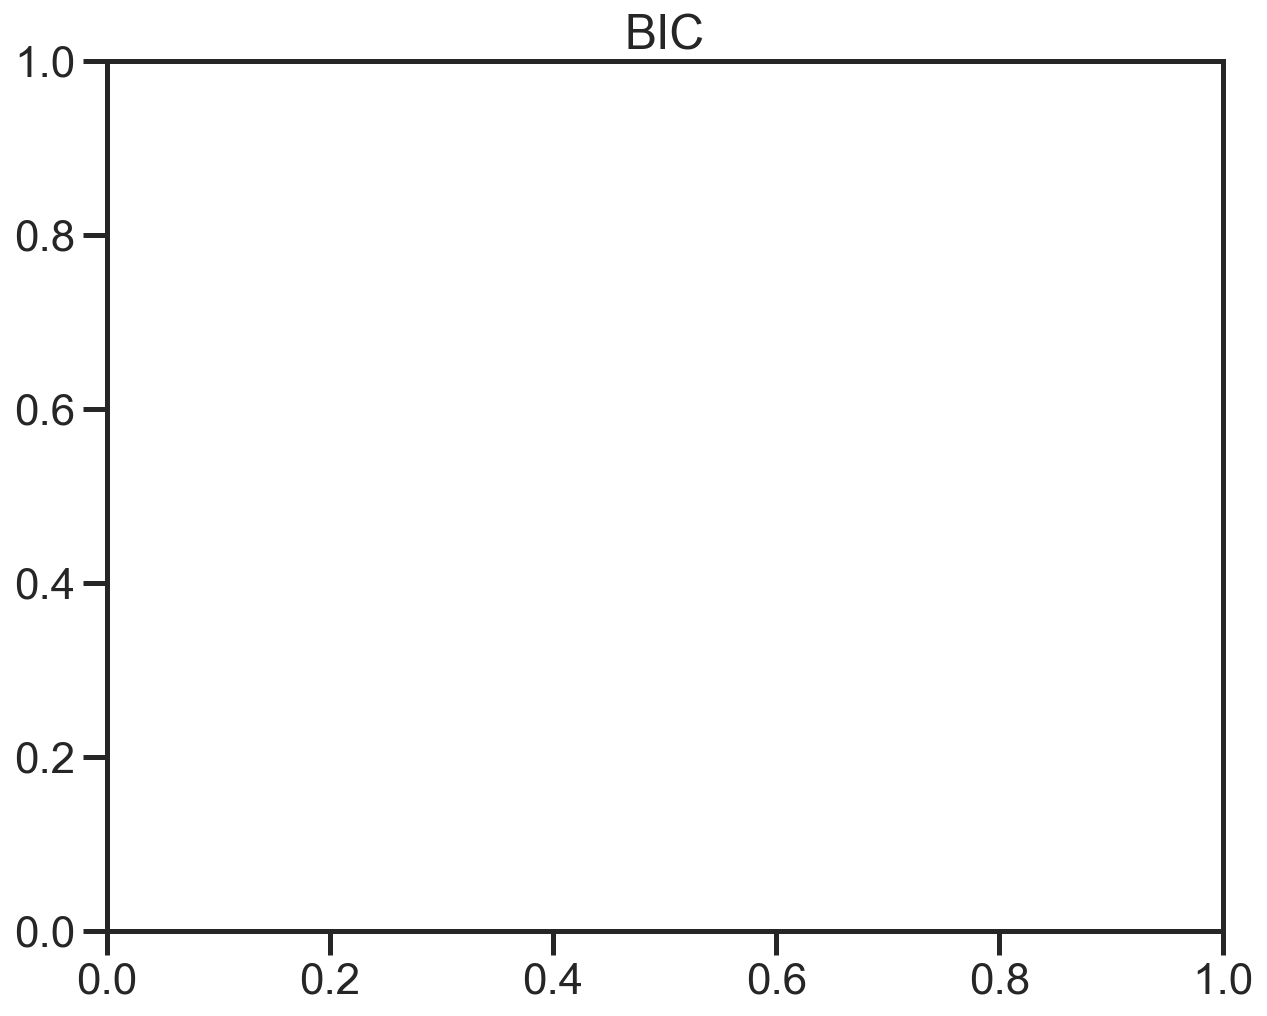

In [55]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.set_title('BIC');

# Alternative model selection method, limited to only searching AR and MA parameters

train_results = sm.tsa.arma_order_select_ic(ts_train, ic=['aic', 'bic'], trend='nc', max_ar=4, max_ma=4)

print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)

# Model Diagnostic Checking
Conduct visual inspection of the residual plots
Residuals of a well-specified ARIMA model should mimic Gaussian white noises: the residuals should be uncorrelated and distributed approximated normally with mean zero and variance 
n^−1
Apparent patterns in the standardized residuals and the estimated ACF of the residuals give an indication that the model need to be re-specified
The results.plot_diagnostics() function conveniently produce several plots to facilitate the investigation.
The estimation results also come with some statistical tests

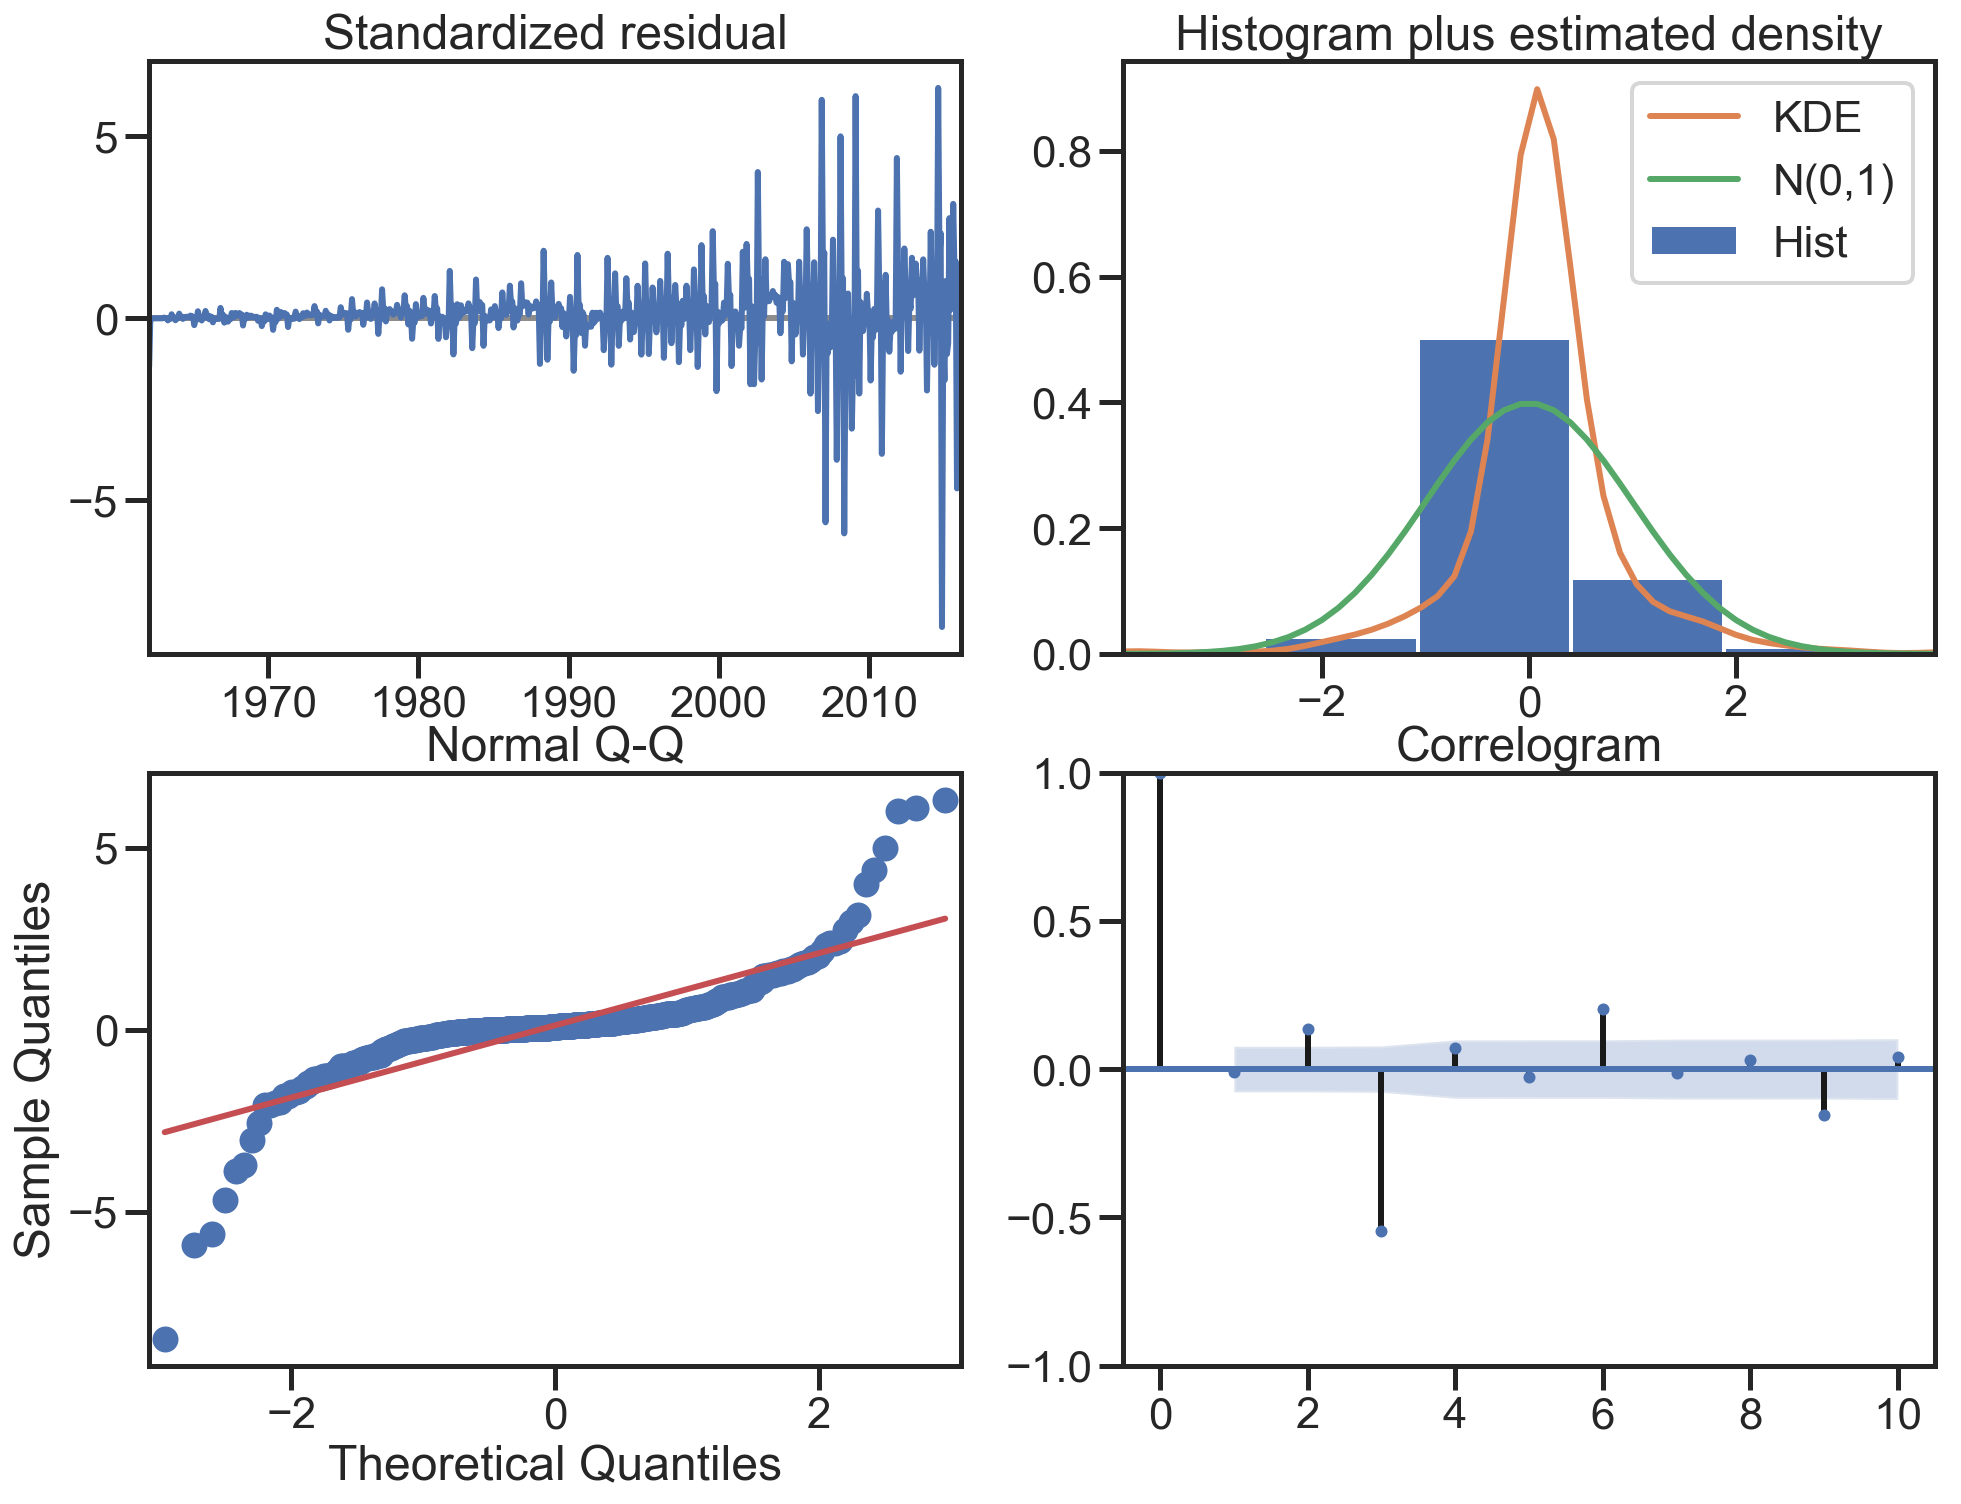

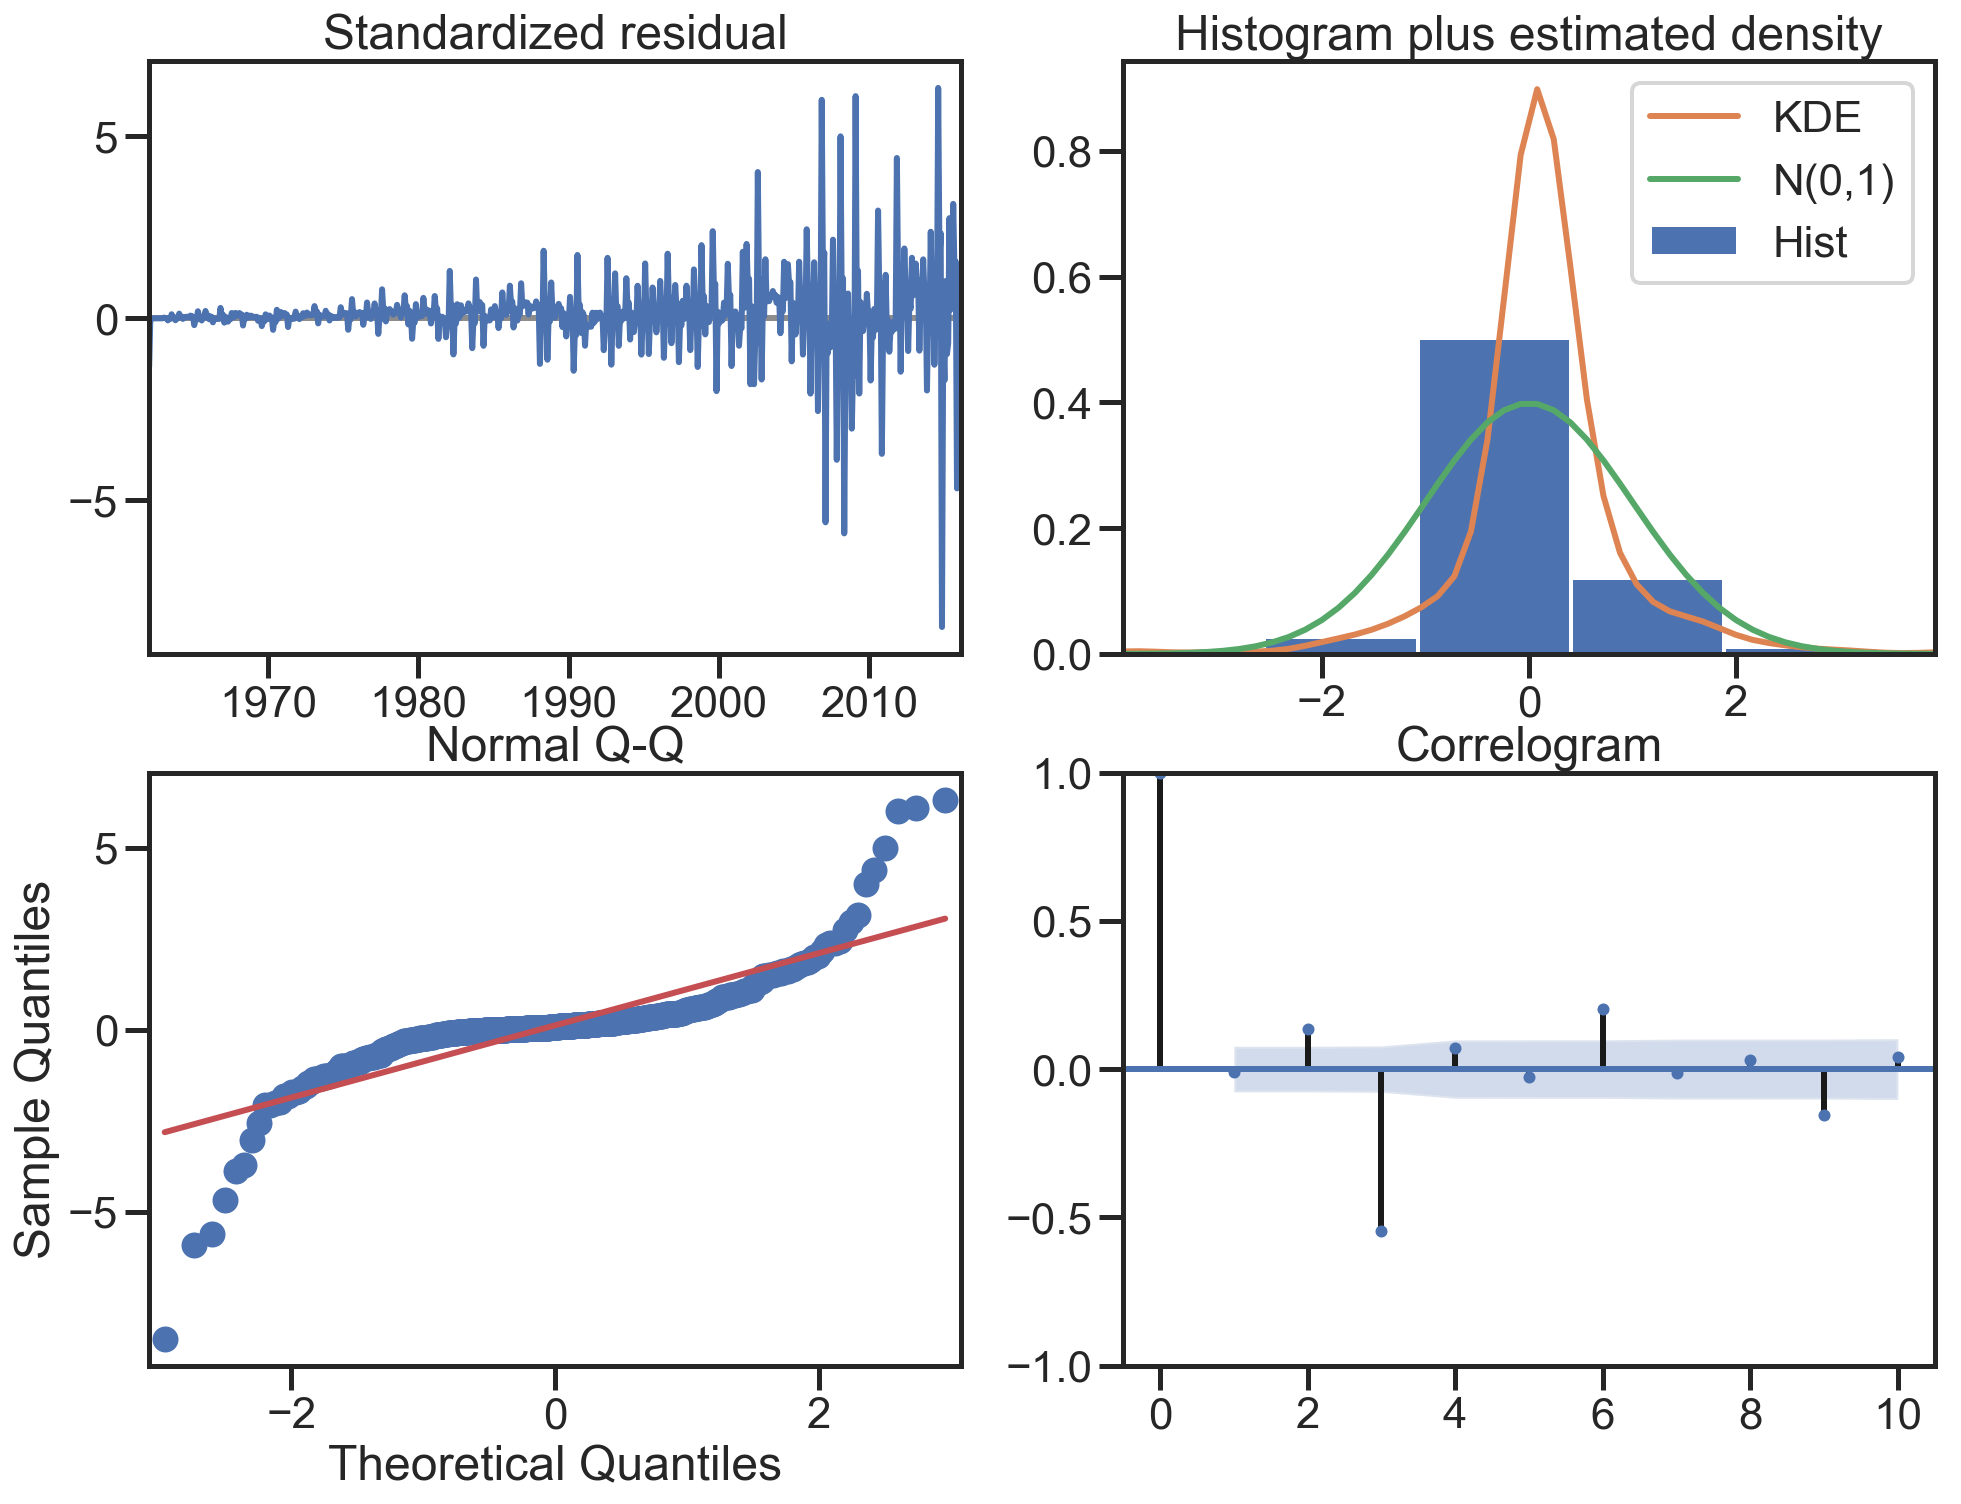

In [57]:
model_results.plot_diagnostics(figsize=(16, 12))

# Formal testing
** More information about the statistics under the parameters table, tests of standardized residuals **
Test of heteroskedasticity
http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity
Test of normality (Jarque-Bera)
http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality
Test of serial correlation (Ljung-Box)
http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_serial_correlation.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_serial_correlation#

In [58]:
# Re-run the above statistical tests, and more. To be used when selecting viable models.

het_method='breakvar'
norm_method='jarquebera'
sercor_method='ljungbox'

(het_stat, het_p) = model_results.test_heteroskedasticity(het_method)[0]
norm_stat, norm_p, skew, kurtosis = model_results.test_normality(norm_method)[0]
sercor_stat, sercor_p = model_results.test_serial_correlation(method=sercor_method)[0]
sercor_stat = sercor_stat[-1] # last number for the largest lag
sercor_p = sercor_p[-1] # last number for the largest lag

# Run Durbin-Watson test on the standardized residuals.
# The statistic is approximately equal to 2*(1-r), where r is the sample autocorrelation of the residuals.
# Thus, for r == 0, indicating no serial correlation, the test statistic equals 2.
# This statistic will always be between 0 and 4. The closer to 0 the statistic,
# the more evidence for positive serial correlation. The closer to 4,
# the more evidence for negative serial correlation.
# Essentially, below 1 or above 3 is bad.
dw = sm.stats.stattools.durbin_watson(model_results.filter_results.standardized_forecasts_error[0, model_results.loglikelihood_burn:])

# check whether roots are outside the unit circle (we want them to be);
# will be True when AR is not used (i.e., AR order = 0)
arroots_outside_unit_circle = np.all(np.abs(model_results.arroots) > 1)
# will be True when MA is not used (i.e., MA order = 0)
maroots_outside_unit_circle = np.all(np.abs(model_results.maroots) > 1)

print('Test heteroskedasticity of residuals ({}): stat={:.3f}, p={:.3f}'.format(het_method, het_stat, het_p));
print('\nTest normality of residuals ({}): stat={:.3f}, p={:.3f}'.format(norm_method, norm_stat, norm_p));
print('\nTest serial correlation of residuals ({}): stat={:.3f}, p={:.3f}'.format(sercor_method, sercor_stat, sercor_p));
print('\nDurbin-Watson test on residuals: d={:.2f}\n\t(NB: 2 means no serial correlation, 0=pos, 4=neg)'.format(dw))
print('\nTest for all AR roots outside unit circle (>1): {}'.format(arroots_outside_unit_circle))
print('\nTest for all MA roots outside unit circle (>1): {}'.format(maroots_outside_unit_circle))


Test heteroskedasticity of residuals (breakvar): stat=83.340, p=0.000

Test normality of residuals (jarquebera): stat=11645.960, p=0.000

Test serial correlation of residuals (ljungbox): stat=320.151, p=0.000

Durbin-Watson test on residuals: d=1.98
	(NB: 2 means no serial correlation, 0=pos, 4=neg)

Test for all AR roots outside unit circle (>1): True

Test for all MA roots outside unit circle (>1): True


# Model performance evaluation (in-sample fit)

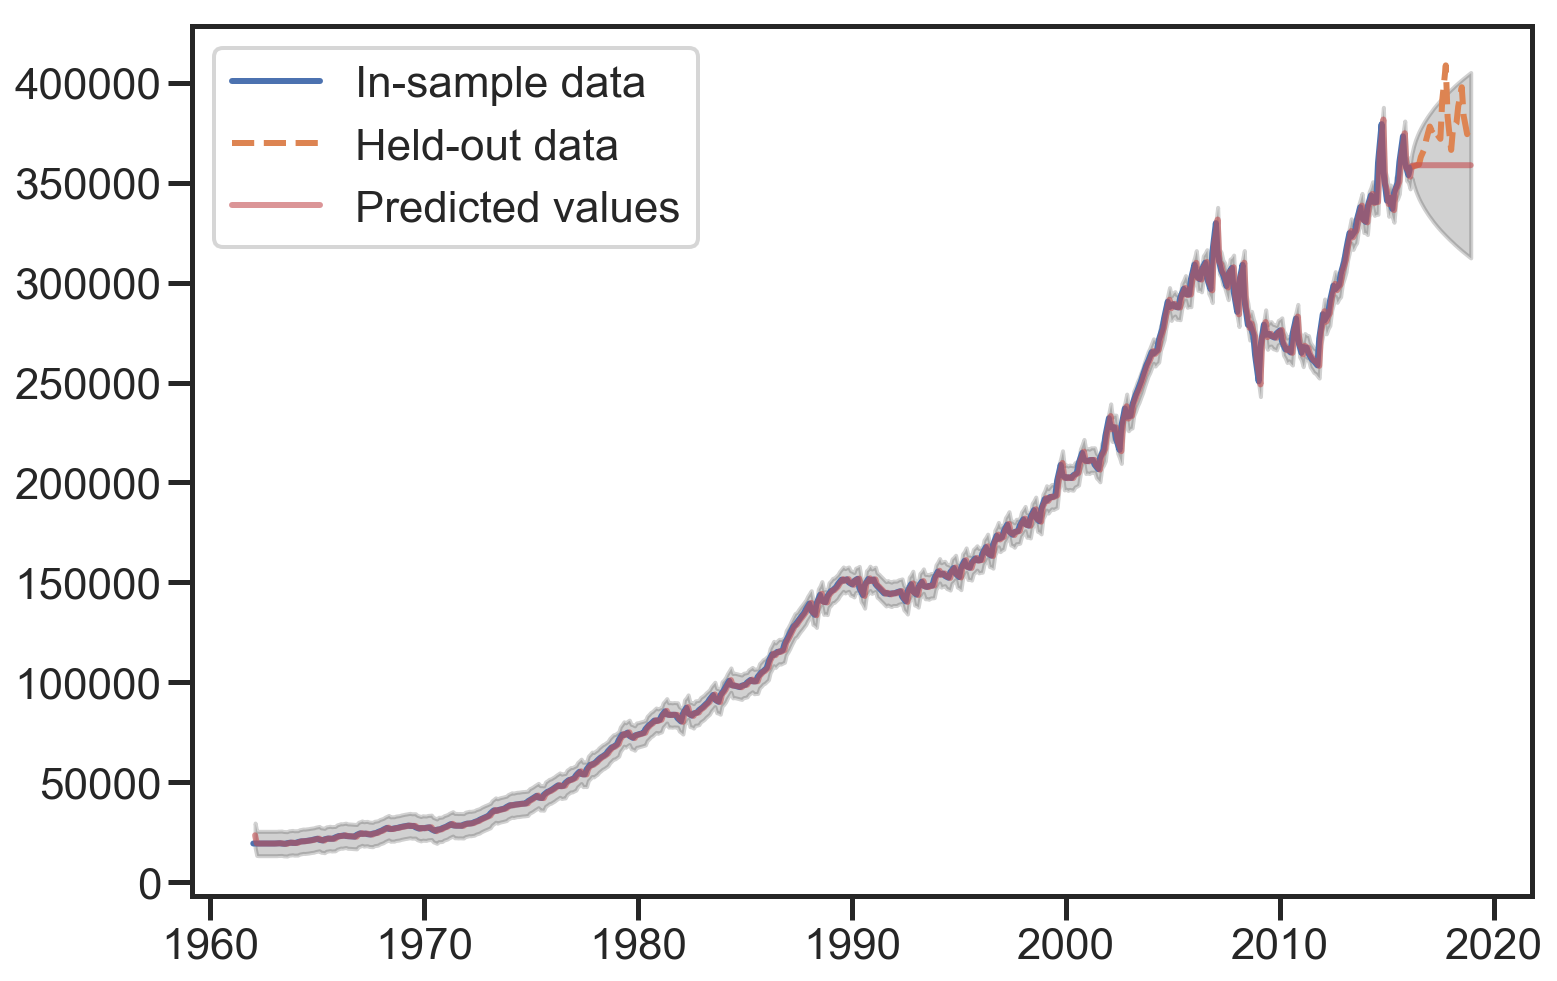

In [59]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(ts_train, label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(ts_test, label='Held-out data', linestyle='--')

# yes DatetimeIndex
pred_begin = ts_train.index[model_results.loglikelihood_burn]
pred_end = ts_test.index[-1]
pred = model_results.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                    end=pred_end.strftime('%Y-%m-%d'))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax1.legend(loc='best');

In [60]:
def get_rmse(y, y_hat):
    '''Root Mean Square Error
    https://en.wikipedia.org/wiki/Root-mean-square_deviation
    '''
    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)

def get_mape(y, y_hat):
    '''Mean Absolute Percent Error
    https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    '''
    perc_err = (100*(y - y_hat))/y
    return np.mean(abs(perc_err))

def get_mase(y, y_hat):
    '''Mean Absolute Scaled Error
    https://en.wikipedia.org/wiki/Mean_absolute_scaled_error
    '''
    abs_err = abs(y - y_hat)
    dsum=sum(abs(y[1:] - y_hat[1:]))
    t = len(y)
    denom = (1/(t - 1))* dsum
    return np.mean(abs_err/denom)

# Forecasting and forecast evaluation

In [61]:
rmse = get_rmse(ts_train, pred_mean.ix[ts_train.index])
print("RMSE: ", rmse)

mape = get_mape(ts_train, pred_mean.ix[ts_train.index])
print("MAPE: ", mape)

mase = get_mase(ts_train, pred_mean.ix[ts_train.index])
print("MASE: ", mase)

RMSE:  3107.9973533354378
MAPE:  0.9894136662051587
MASE:  0.9999999999999991


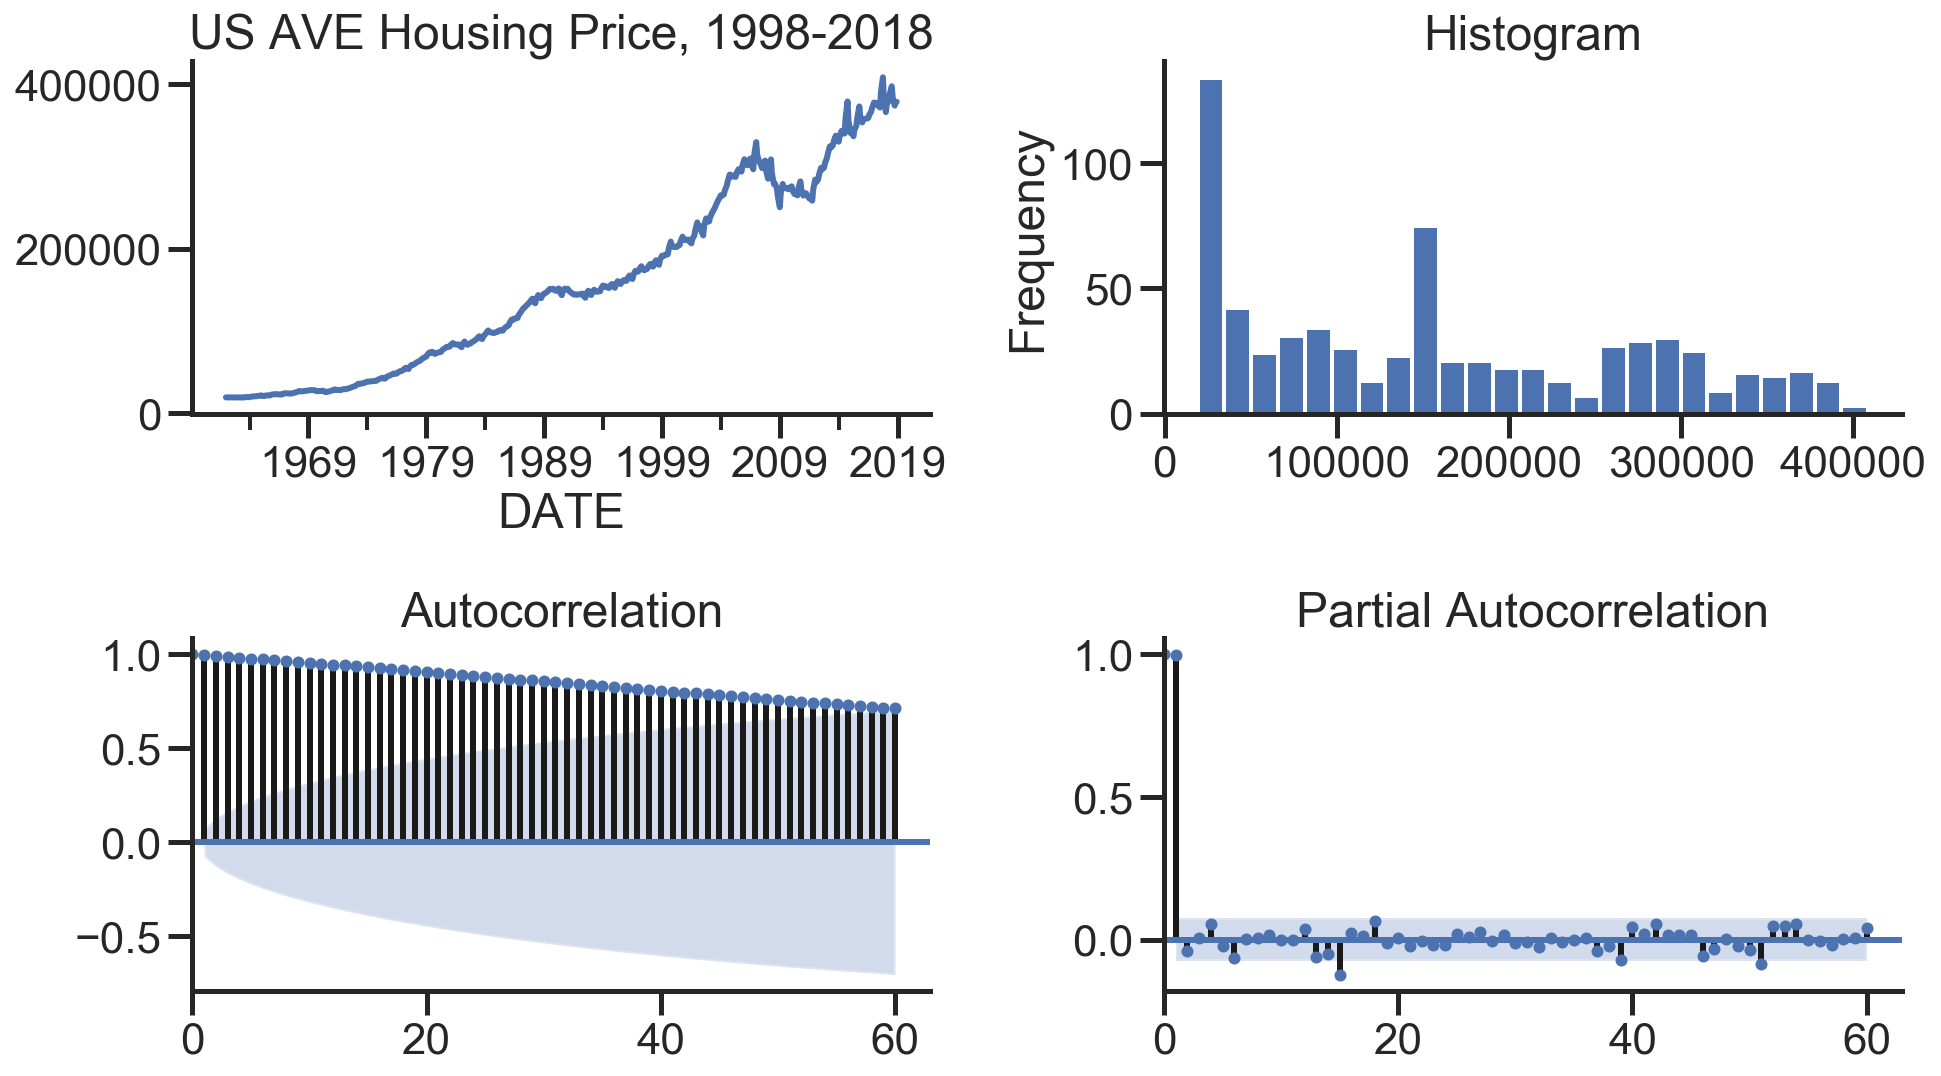

In [62]:
tsplot(ts_df, title='US AVE Housing Price, 1998-2018', lags=60);

# Building a Seasonal ARIMA Model for Forecasting

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 684 entries, 1962-01-01 to 2018-12-01
Data columns (total 4 columns):
ASPUS_M                     684 non-null float64
ASPUS_M_log                 684 non-null float64
ASPUS_M_log_diff            683 non-null float64
ASPUS_M_log_diff_rescale    684 non-null float64
dtypes: float64(4)
memory usage: 26.7 KB


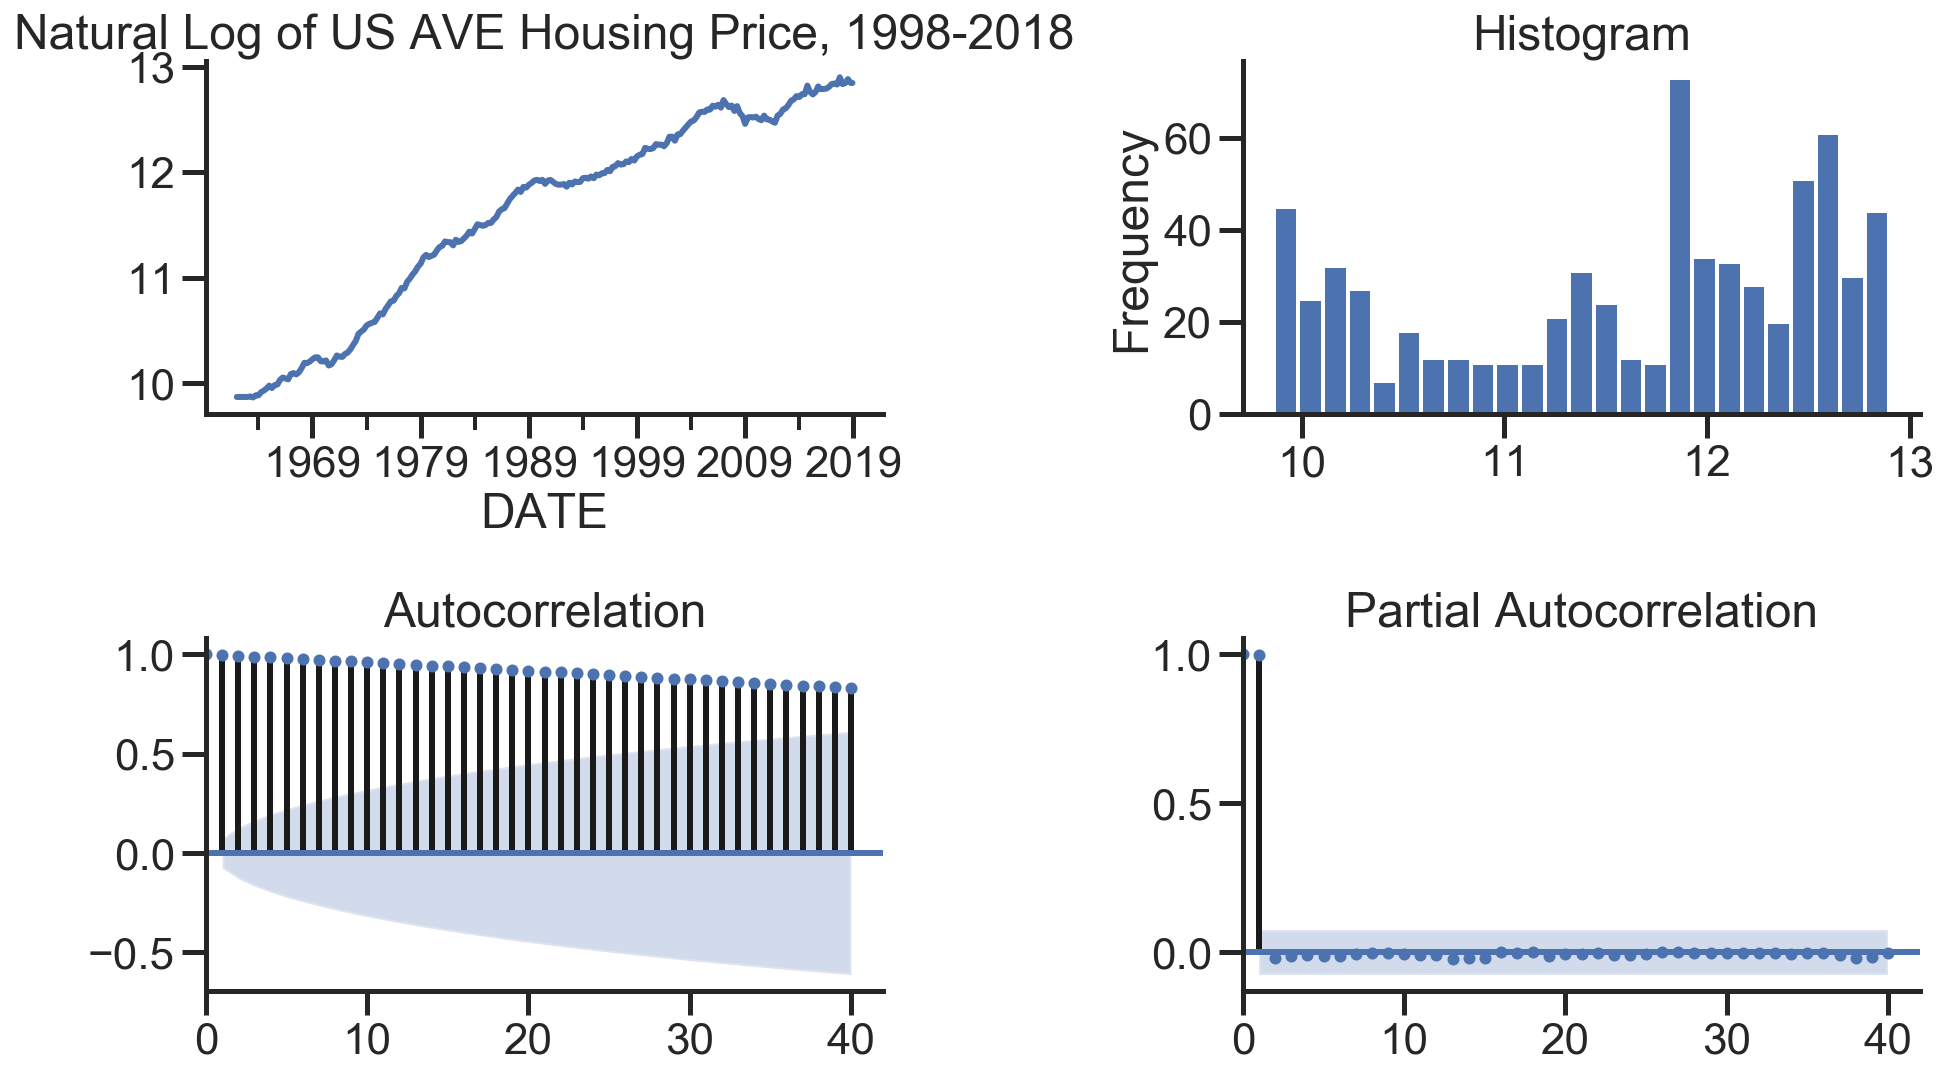

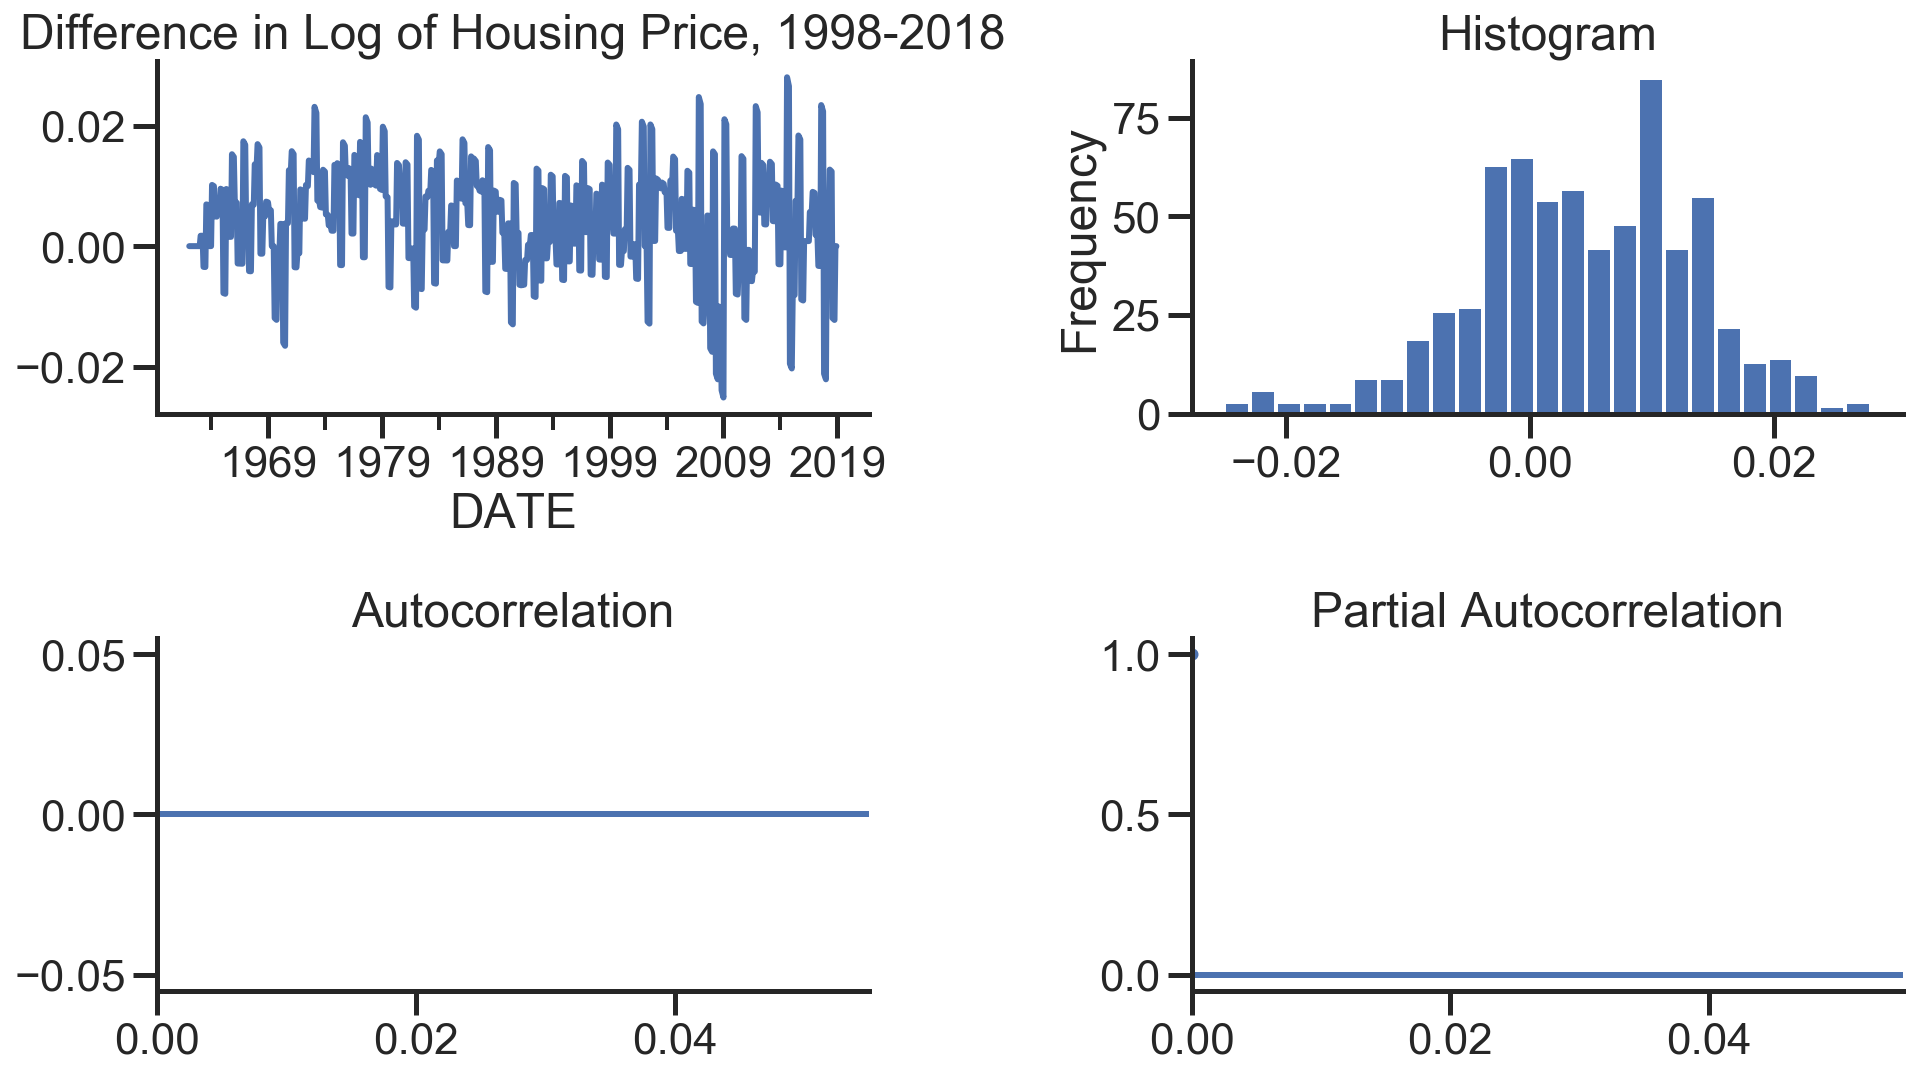

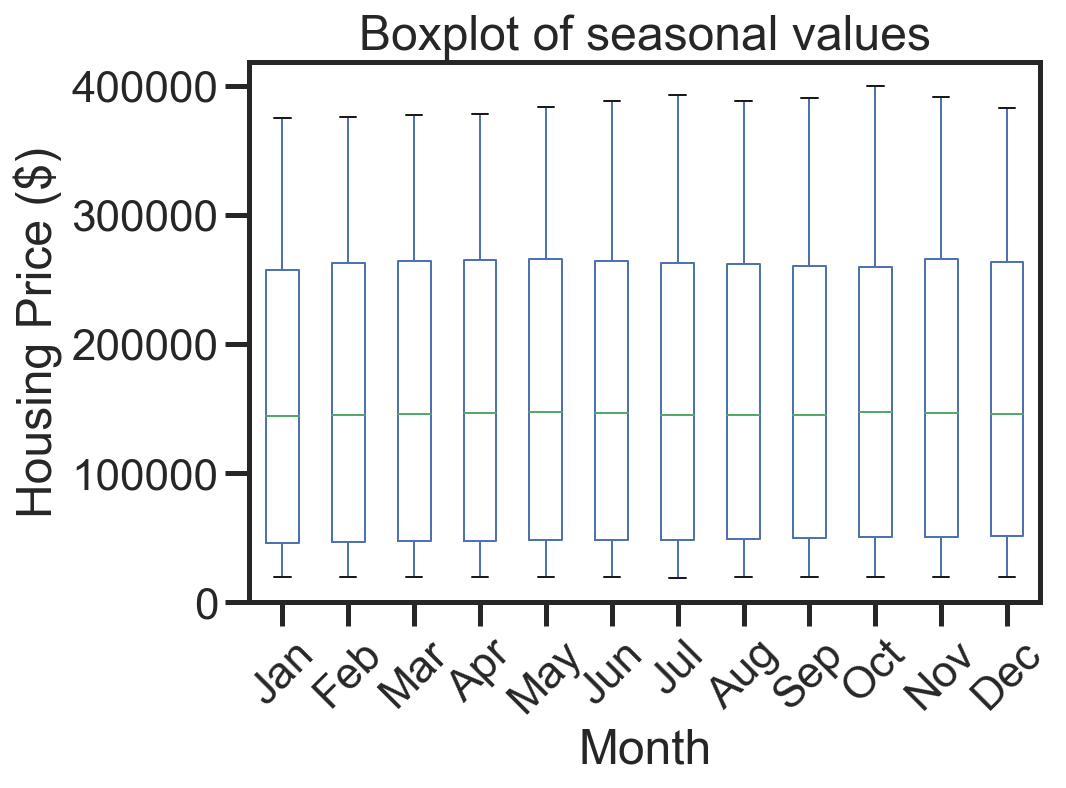

In [63]:
h_m_df.info()
h_m_df['ASPUS_M_log'] = h_m_df['ASPUS_M'].apply(lambda x: np.log(x))

h_m_df['ASPUS_M_log_diff'] = h_m_df['ASPUS_M_log'].diff()

h_m_df['ASPUS_M_log_diff_rescale'] = np.exp(h_m_df['ASPUS_M_log_diff'] + h_m_df['ASPUS_M_log'])
h_m_df['ASPUS_M_log_diff_rescale']=h_m_df['ASPUS_M_log_diff_rescale'].fillna(method='bfill')

X3= h_m_df['ASPUS_M_log_diff_rescale']

tsplot(h_m_df['ASPUS_M_log'], title='Natural Log of US AVE Housing Price, 1998-2018', lags=40);

tsplot(h_m_df['ASPUS_M_log_diff'], title='Difference in Log of Housing Price, 1998-2018', lags=40);

######### Box Plot for seasonality
h_m_df['Month'] = h_m_df.index.strftime('%b')
h_m_df['Year'] = h_m_df.index.year

h_m_df_piv = h_m_df.pivot(index='Year', columns='Month', values='ASPUS_M')

h_m_df = h_m_df.drop(['Month', 'Year'], axis=1)

# put the months in order
month_names = pd.date_range(start='2000-01-01', periods=12, freq='MS').strftime('%b')
h_m_df_piv = h_m_df_piv.reindex(columns=month_names)

# plot it
fig, ax = plt.subplots(figsize=(8, 6))
h_m_df_piv.plot(ax=ax, kind='box');

ax.set_xlabel('Month');
ax.set_ylabel('Housing Price ($)');
ax.set_title('Boxplot of seasonal values');
plt.xticks(rotation = 45)
ax.xaxis.set_ticks_position('bottom')
fig.tight_layout();

In [64]:
# Housing Average Price Monthly Series
mod = sm.tsa.statespace.SARIMAX(ts_train, order=(2,1,0), seasonal_order=(1,1,0,12), )
sarima_fit1 = mod.fit()
print(sarima_fit1.summary())


mod = sm.tsa.statespace.SARIMAX(ts_train, order=(0,1,1), seasonal_order=(0,1,0,12))
sarima_fit2 = mod.fit()
print(sarima_fit2.summary())

                                 Statespace Model Results                                 
Dep. Variable:           ASPUS_M_log_diff_rescale   No. Observations:                  650
Model:             SARIMAX(2, 1, 0)x(1, 1, 0, 12)   Log Likelihood               -6136.007
Date:                            Thu, 28 Mar 2019   AIC                          12280.014
Time:                                    04:50:55   BIC                          12297.841
Sample:                                01-01-1962   HQIC                         12286.935
                                     - 02-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1984      0.050      3.979      0.000       0.101       0.296
ar.L2          0.0053      0.040   

Notice an additional argument simple_differencing=True. 
This controls how the order of integration is handled in ARIMA models. 
If simple_differencing=True, then the time series provided as endog is literally differenced and an ARMA model is fit to the resulting new time series. This implies that a number of initial periods are lost to the differencing process, however it may be necessary either to compare results to other packages (e.g. Stata's arima always uses simple differencing) or if the seasonal periodicity is large

# Model Diagnostic

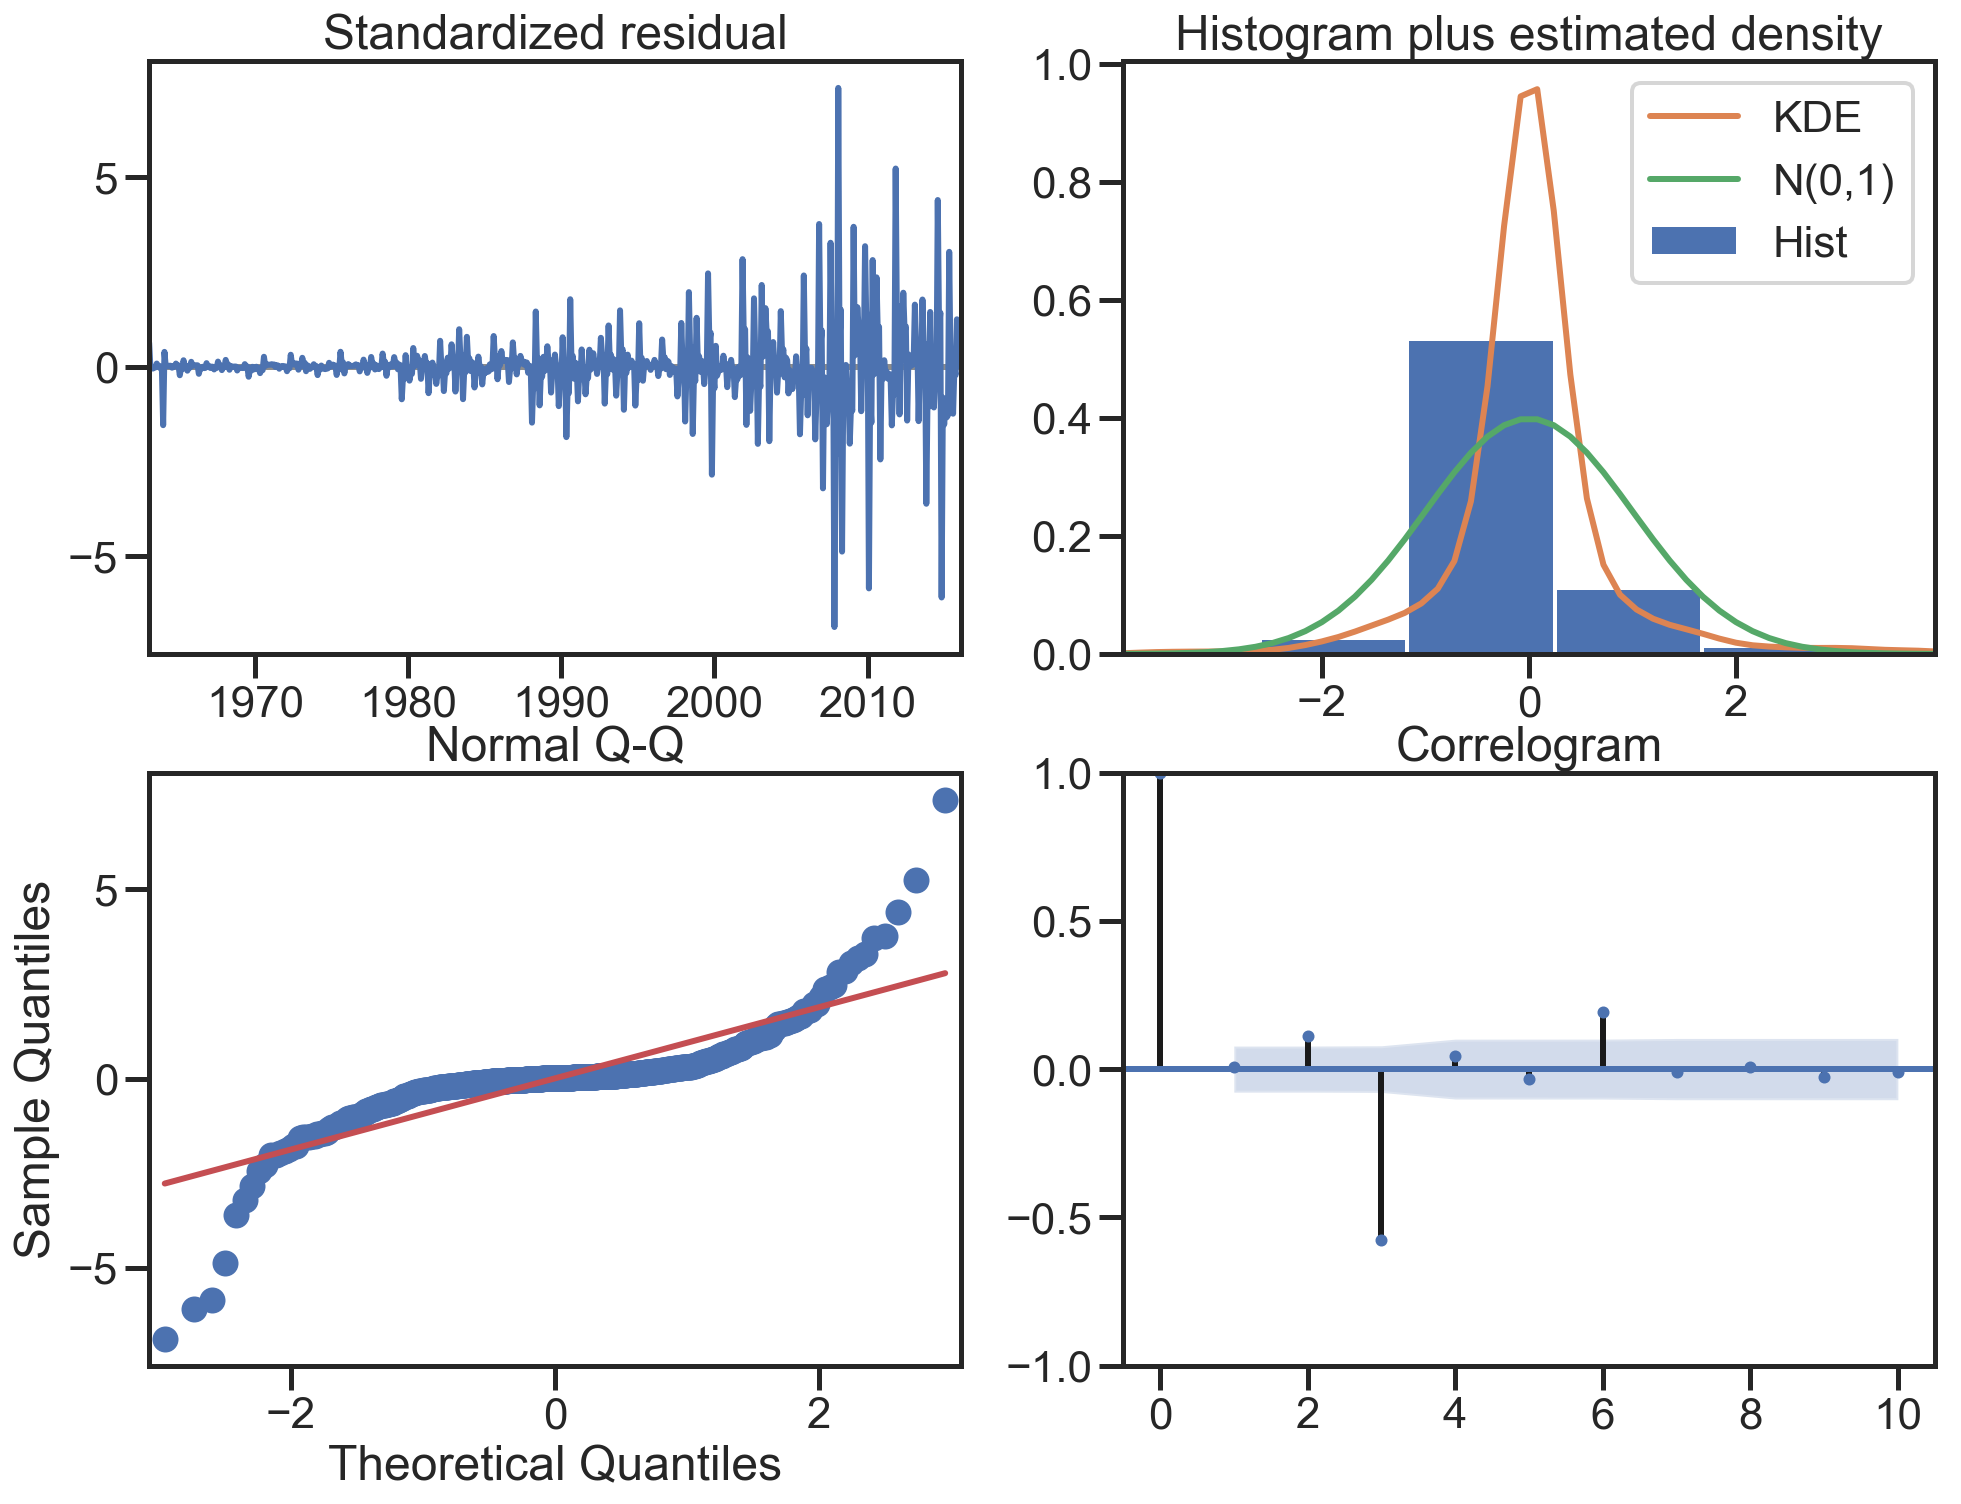

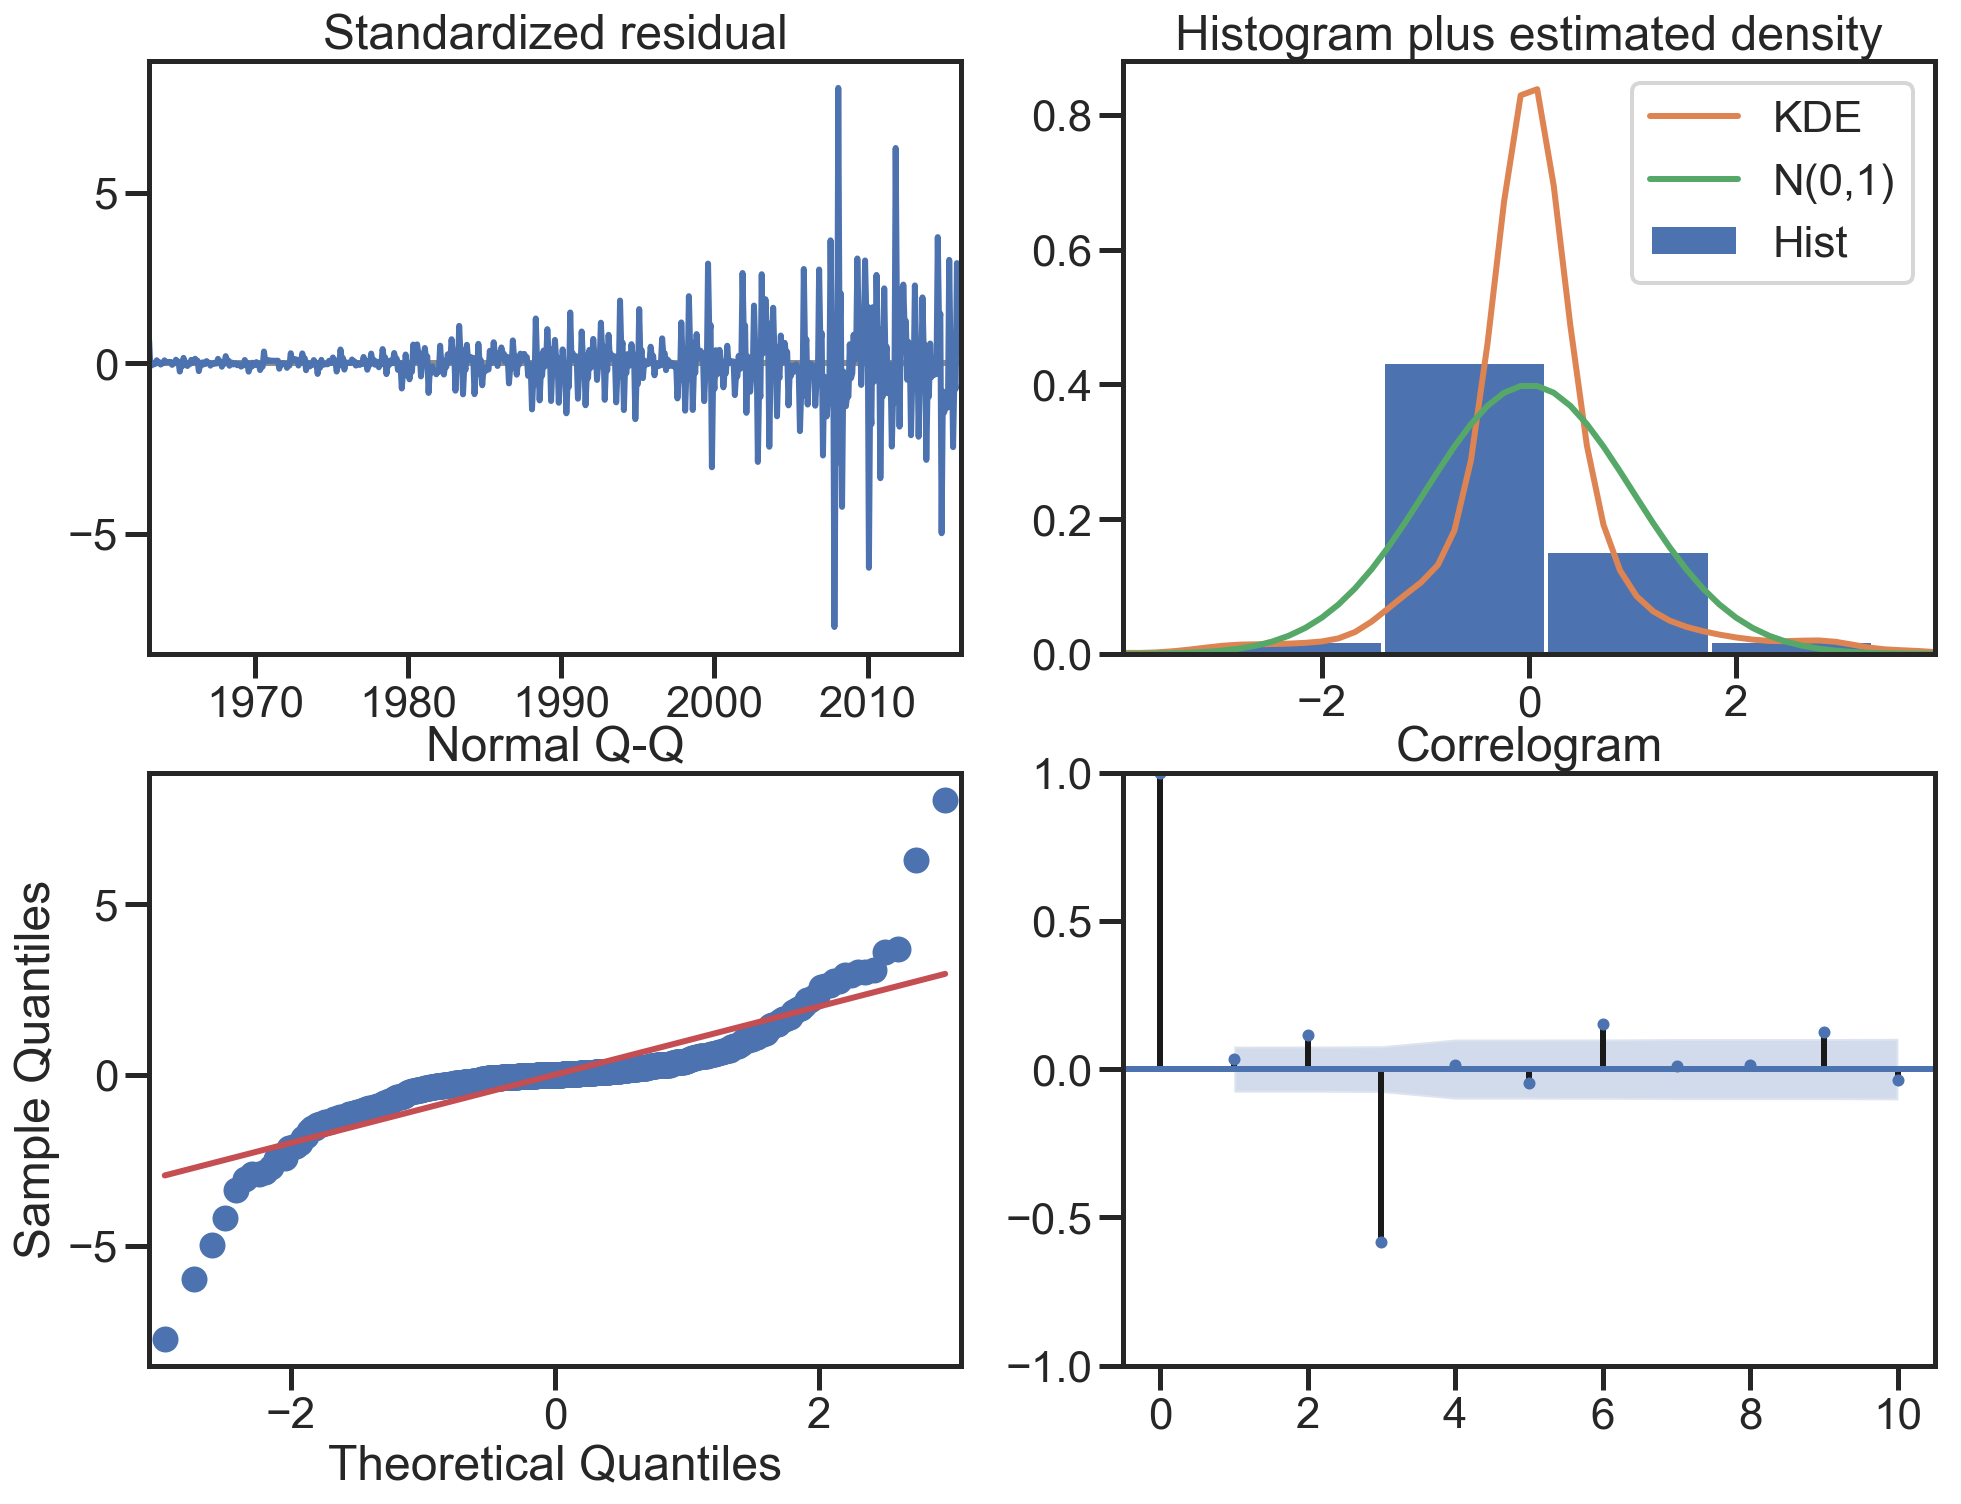

In [65]:


sarima_fit1.plot_diagnostics(figsize=(16, 12));

sarima_fit2.plot_diagnostics(figsize=(16, 12));

(650,)
(34,)
Training Series Tail: 
 DATE
2015-10-01   373248.21425
2015-11-01   360261.84293
2015-12-01   357028.76305
2016-01-01   353795.68801
2016-02-01   357600.25210
Name: ASPUS_M_log_diff_rescale, dtype: float64 

Testing Series Head: 
 DATE
2016-03-01   357900.25189
2016-04-01   358200.25168
2016-05-01   358500.25147
2016-06-01   358800.25126
2016-07-01   359100.25105
Name: ASPUS_M_log_diff_rescale, dtype: float64


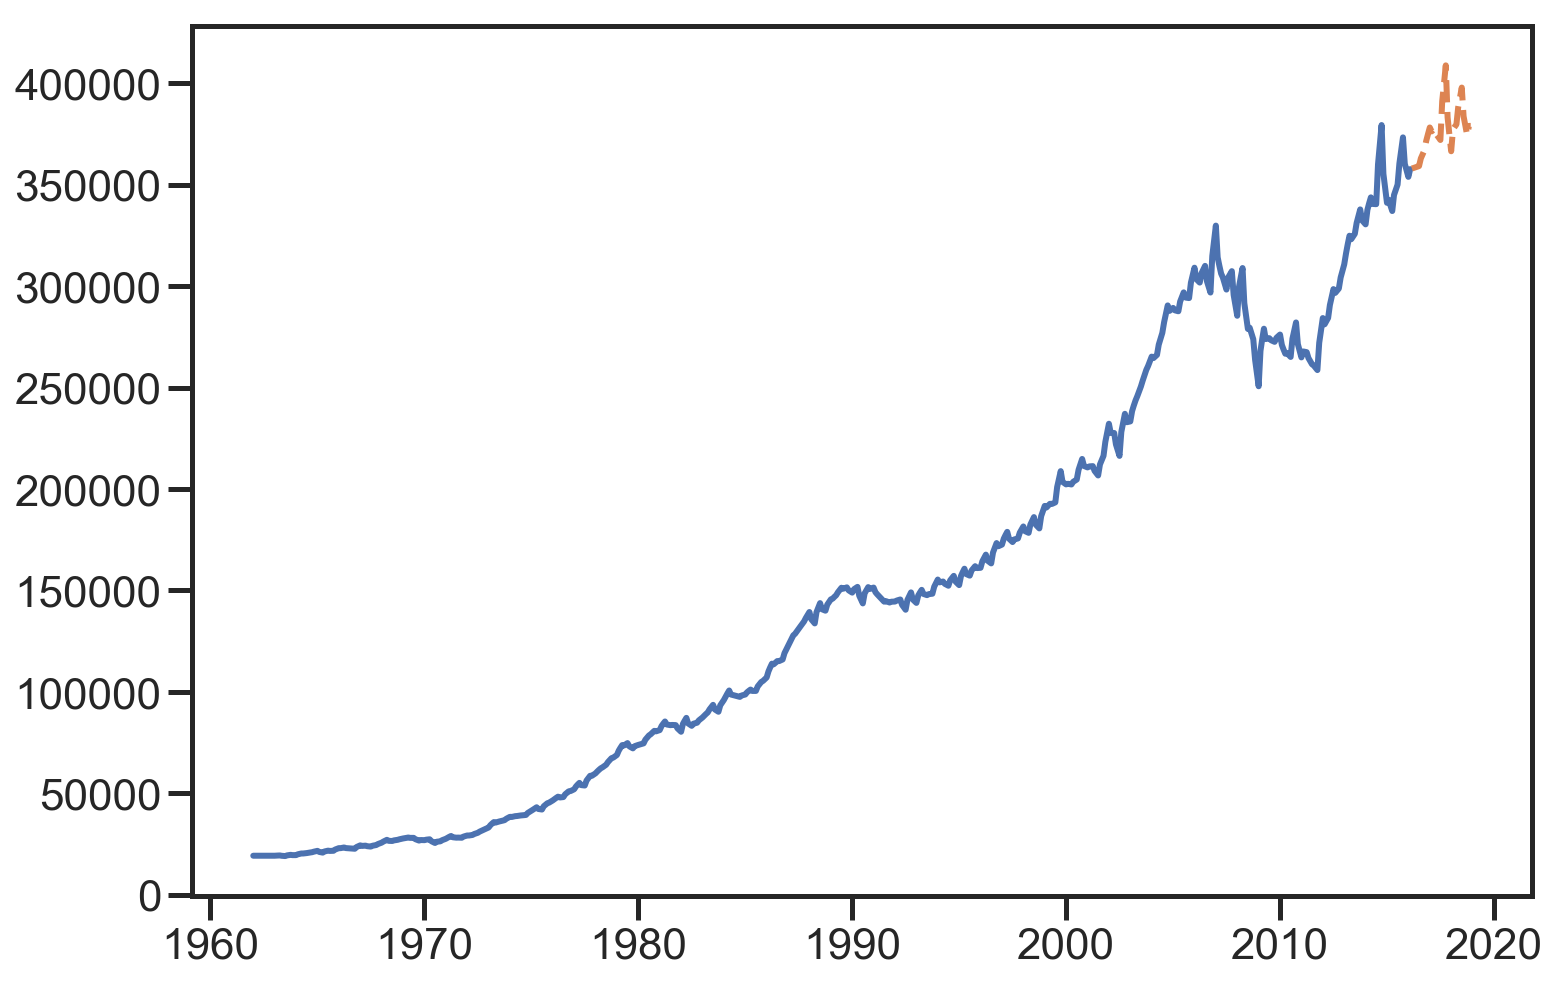

In [66]:
n_train=int(0.95*n_sample)+1
n_forecast=n_sample-n_train
#ts_df
ts_train = h_m_df.iloc[:n_train]['ASPUS_M_log_diff_rescale']
ts_test = h_m_df.iloc[n_train:]['ASPUS_M_log_diff_rescale']
print(ts_train.shape)
print(ts_test.shape)
print("Training Series Tail:", "\n", ts_train.tail(), "\n")
print("Testing Series Head:", "\n", ts_test.head())


# Step 5: Do a 14-step ahead forecast

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(ts_train, label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(ts_test, label='Held-out data', linestyle='--')


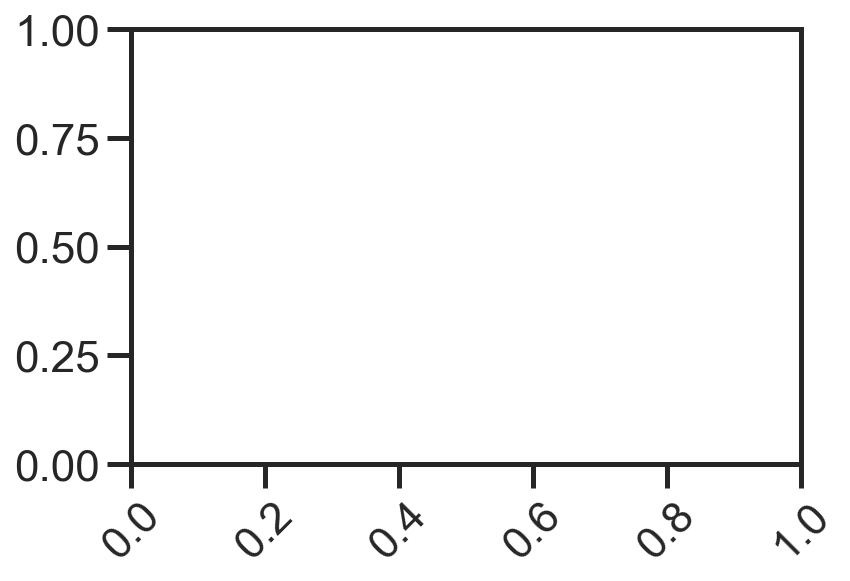

In [67]:
# yes DatetimeIndex
pred_begin = ts_train.index[sarima_fit2.loglikelihood_burn]
pred_end = ts_test.index[-1]
pred = sarima_fit2.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                    end=pred_end.strftime('%Y-%m-%d'))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)
ax1.set_xlabel("Year")
ax1.set_ylabel("Housing Price ($) ")
ax1.legend(loc='best');
ax.set_title('US AVE Housing Price Since 1962');
plt.xticks(rotation = 45)
ax.xaxis.set_ticks_position('bottom')
fig.tight_layout();

Text(0.5, 1.0, 'RSS: nan')

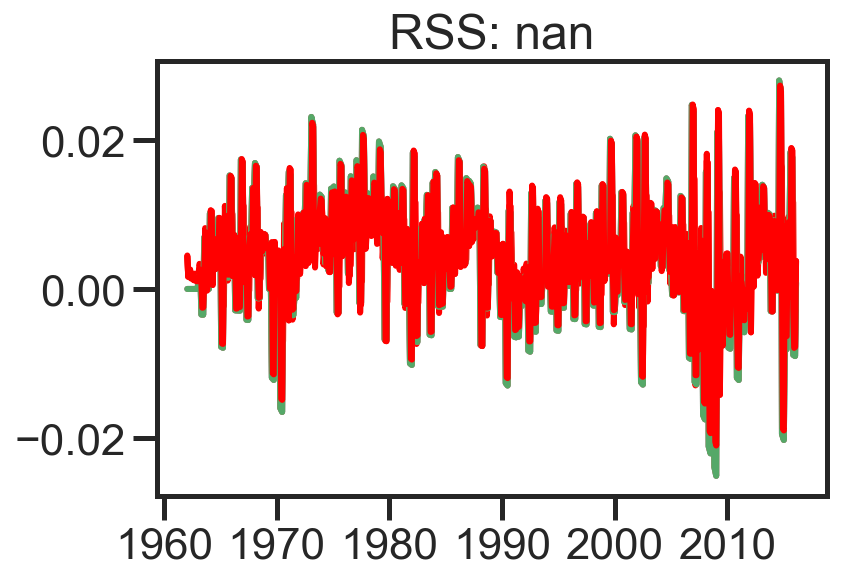

In [68]:
#AR MODEL

ts_log= h_m_df.iloc[:n_train]['ASPUS_M_log']
ts_log_diff= h_m_df.iloc[:n_train]['ASPUS_M_log_diff']

model = ARIMA(ts_log, order=(2,1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

#MA Model
model = ARIMA(ts_log, order=(1, 1, 6))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

#Combined Model
model = ARIMA(ts_log, order=(2, 1, 6))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

Taking it back to original scale
Since the combined model gave best result, lets scale it back to the original values and see how well it performs there. First step would be to store the predicted results as a separate series and observe it.

In [69]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())
                                                                                                                                                                                                                                                                                                                    
                                                                                                                                                                                                                                                                                                                    
'''first determine the cumulative sum at index and then add it to the base number. The cumulative sum can be found as:'''

predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())
print (predictions_ARIMA_diff_cumsum.tail())

'''Next we’ve to add them to base number. For this lets create a series with all values as base number and add the differences to it. This can be done as:'''

predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

DATE
1962-02-01   0.00436
1962-03-01   0.00163
1962-04-01   0.00201
1962-05-01   0.00261
1962-06-01   0.00141
dtype: float64
DATE
1962-02-01   0.00436
1962-03-01   0.00599
1962-04-01   0.00800
1962-05-01   0.01061
1962-06-01   0.01202
dtype: float64
DATE
2015-10-01   2.92292
2015-11-01   2.92026
2015-12-01   2.91233
2016-01-01   2.90452
2016-02-01   2.90828
dtype: float64


DATE
1962-01-01   9.86786
1962-02-01   9.87222
1962-03-01   9.87385
1962-04-01   9.87586
1962-05-01   9.87847
dtype: float64

Here the first element is base number itself and from thereon the values cumulatively added. Last step is to take the exponent and compare with the original series.

Text(0.5, 1.0, 'RMSE: nan')

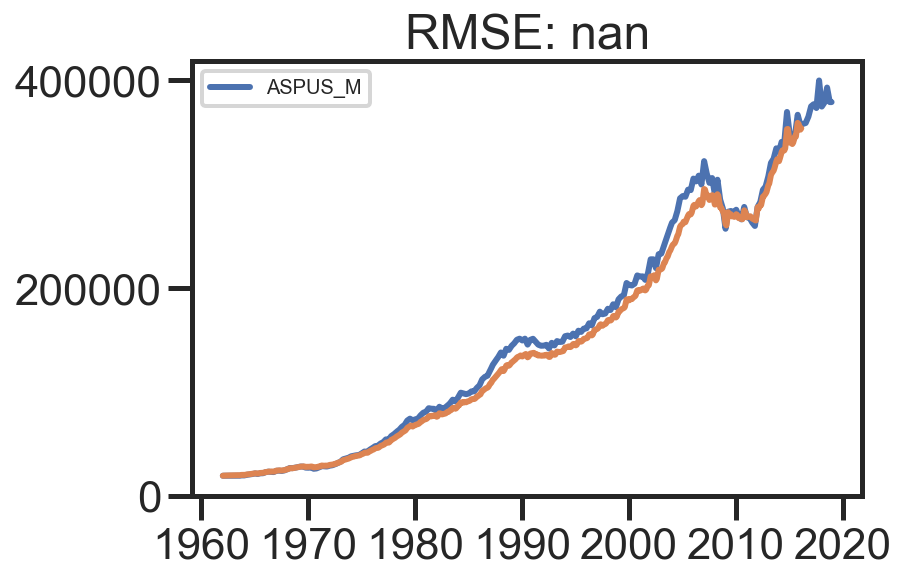

In [70]:
ts=h_m_df['ASPUS_M']
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.legend(fontsize=10)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))



Text(0.5, 1.0, 'RMSE: nan')

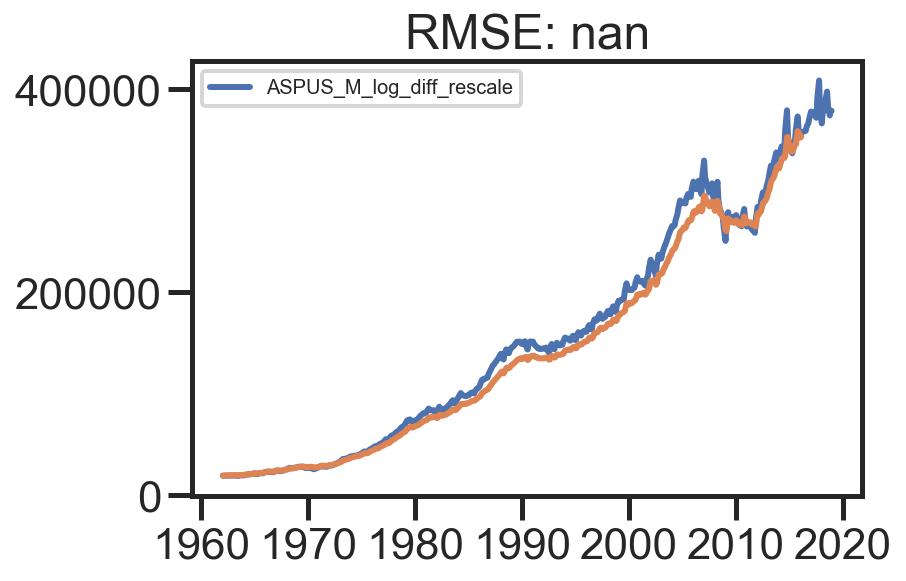

In [71]:
#Comparing last meathod

h_m_df['ASPUS_M_log_diff_rescale'] = np.exp(h_m_df['ASPUS_M_log_diff'] + h_m_df['ASPUS_M_log'])
h_m_df['ASPUS_M_log_diff_rescale']=h_m_df['ASPUS_M_log_diff_rescale'].fillna(method='bfill')

X3= h_m_df['ASPUS_M_log_diff_rescale']

predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(X3)
plt.plot(predictions_ARIMA)
plt.legend(fontsize=10)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(X3)))


# ARIMA

[378594.60349]
[356195.53687]


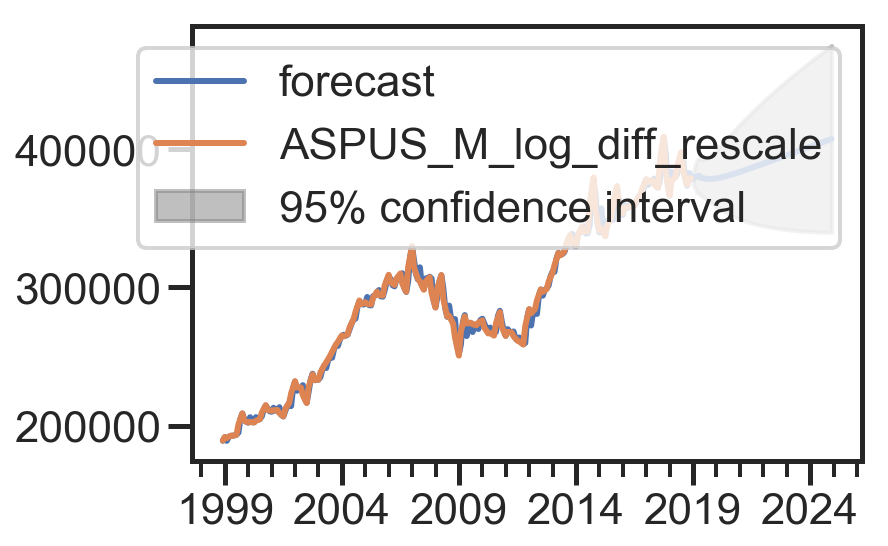

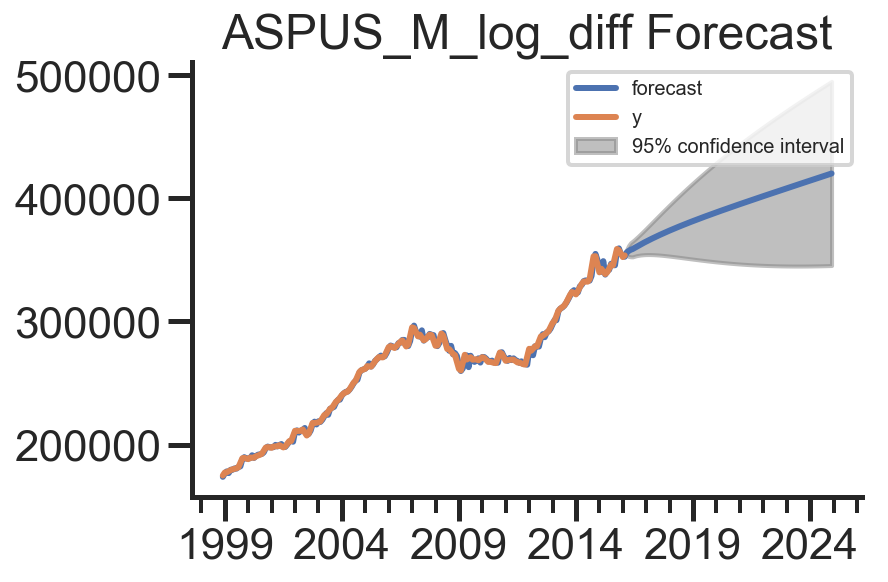

In [72]:
X3= h_m_df['ASPUS_M_log_diff_rescale']

X3 = sm.tsa.ARIMA(X3, (3, 1, 6)).fit()
predictions = X3.forecast()[0]
print(predictions)
#X3.plot_predict(start='12-01-98', end='12-01-2024')
fig, ax = plt.subplots()
X3.plot_predict(start='12-01-1998', end='12-01-2024', ax=ax, dynamic=False, plot_insample=True)

X2 = predictions_ARIMA
X2 = sm.tsa.ARIMA(X2, (3, 1, 6)).fit()
predictions = X2.forecast()[0]
print(predictions)
#X3.plot_predict(start='12-01-98', end='12-01-2024')
fig, ax = plt.subplots()
X2.plot_predict(start='12-01-1998', end='12-01-2024', ax=ax, dynamic=False, plot_insample=True)


#X3.plot(figsize=(12,8))
plt.legend(bbox_to_anchor=(1.25, 0.5))
sns.despine()
plt.legend(fontsize=10)
plt.title('ASPUS_M_log_diff Forecast')
plt.show()

#  ARMA

[378955.07725]
[355650.60719]


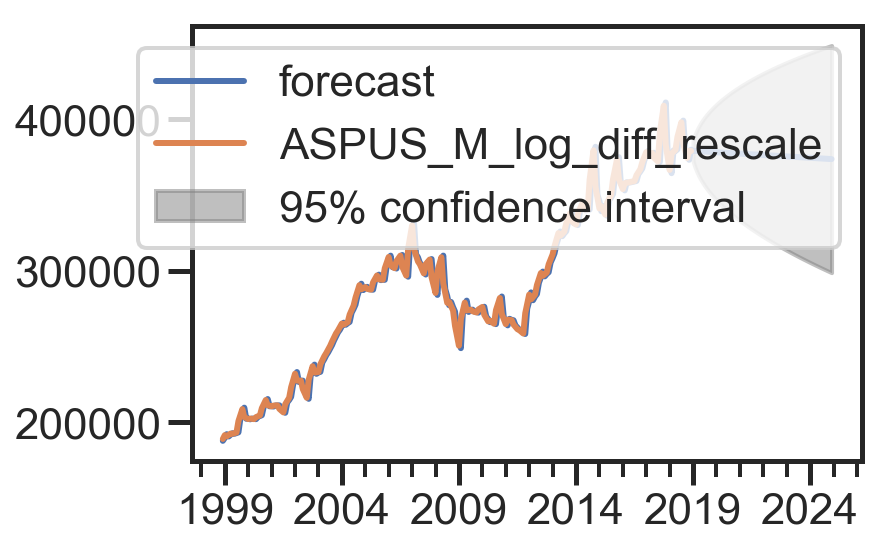

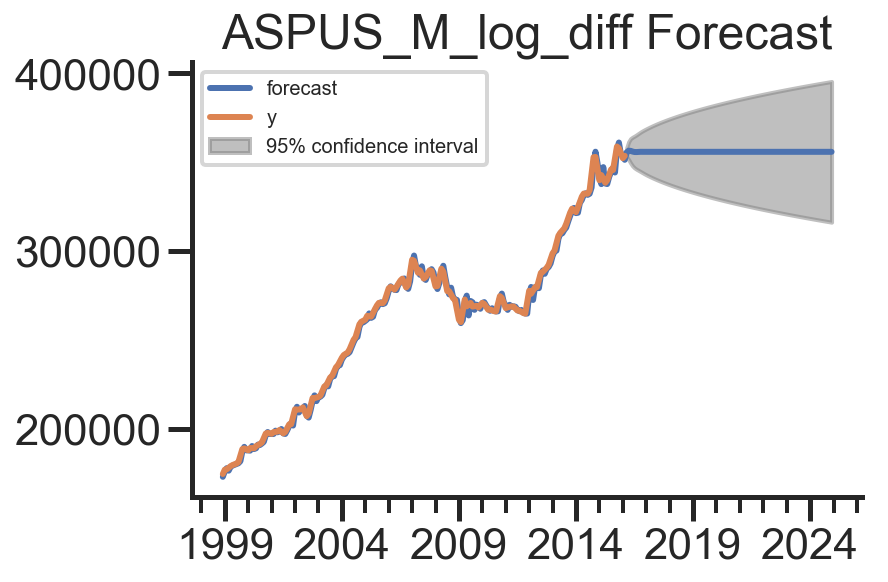

In [73]:
X3= h_m_df['ASPUS_M_log_diff_rescale']

X3 = sm.tsa.ARMA(X3, (3, 0, 6)).fit()
predictions = X3.forecast()[0]
print(predictions)
#X3.plot_predict(start='12-01-98', end='12-01-2024')
fig, ax = plt.subplots()
X3.plot_predict(start='12-01-1998', end='12-01-2024', ax=ax, dynamic=False, plot_insample=True)

X2 = predictions_ARIMA
X2 = sm.tsa.ARMA(X2, (3, 0, 6)).fit()
predictions = X2.forecast()[0]
print(predictions)
#X3.plot_predict(start='12-01-98', end='12-01-2024')
fig, ax = plt.subplots()
X2.plot_predict(start='12-01-1998', end='12-01-2024', ax=ax, dynamic=False, plot_insample=True)


#X3.plot(figsize=(12,8))
plt.legend(bbox_to_anchor=(1.25, 0.5))
sns.despine()
plt.legend(fontsize=10)
plt.title('ASPUS_M_log_diff Forecast')
plt.show()